Sledge 1:
present 282  Deliver from (20, 131) to (10, 783)
present 232  Deliver from (73, 801) to (159, 839)
Sledge 2:
present 162  Deliver from (176, 19) to (653, 427)
Sledge 3:
present 229  Deliver from (200, 3) to (212, 615)
Sledge 4:
present 297  Deliver from (3, 203) to (346, 877)
present 64  Deliver from (335, 892) to (718, 421)
present 220  Deliver from (677, 424) to (140, 795)
Sledge 5:
present 210  Deliver from (47, 173) to (657, 151)
present 105  Deliver from (654, 147) to (732, 939)
Sledge 6:
present 207  Deliver from (155, 104) to (256, 845)
Sledge 7:
present 257  Deliver from (212, 48) to (83, 988)
Sledge 8:
present 194  Deliver from (123, 156) to (298, 128)
present 106  Deliver from (310, 163) to (799, 285)
present 290  Deliver from (768, 283) to (770, 992)
Sledge 9:
present 291  Deliver from (285, 20) to (605, 565)
present 144  Deliver from (587, 566) to (259, 987)
Sledge 10:
present 94  Deliver from (290, 20) to (274, 198)
present 187  Deliver from (291, 207) to (569, 2

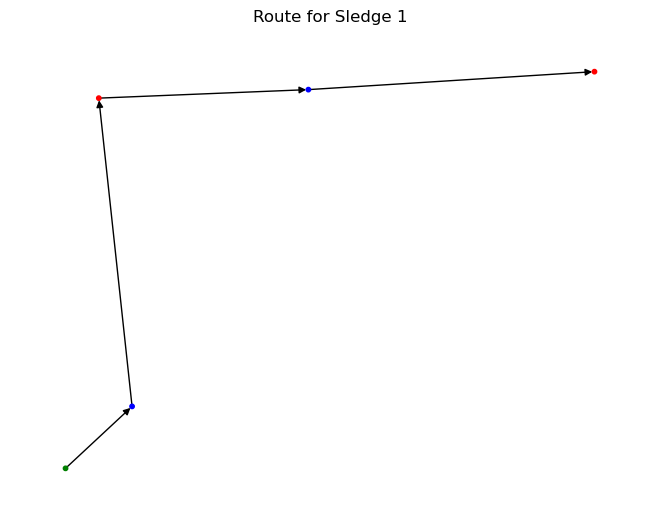

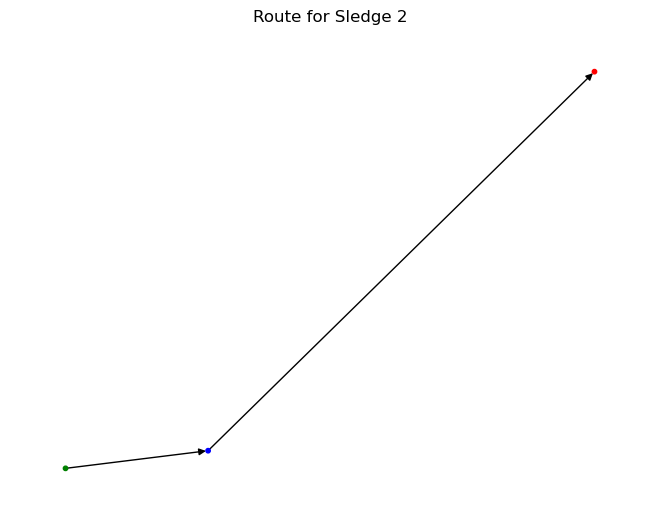

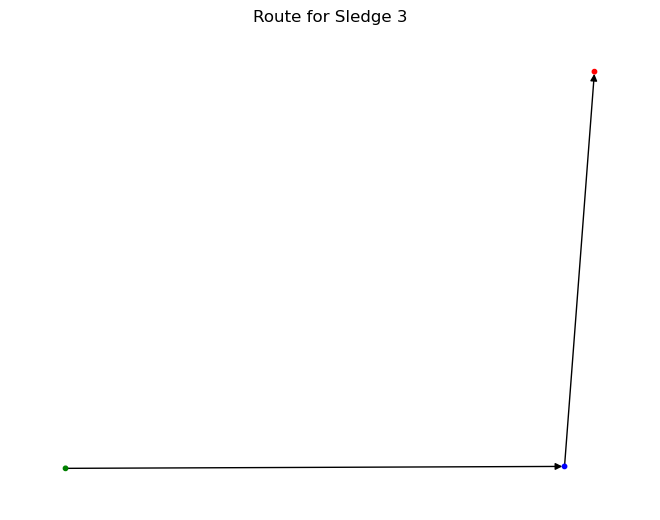

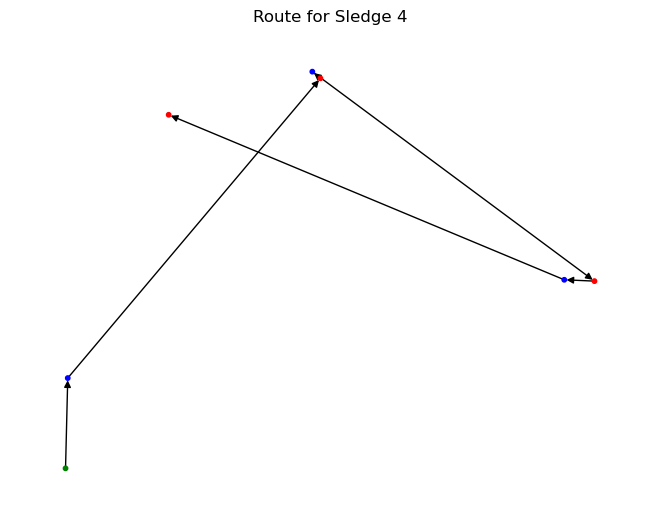

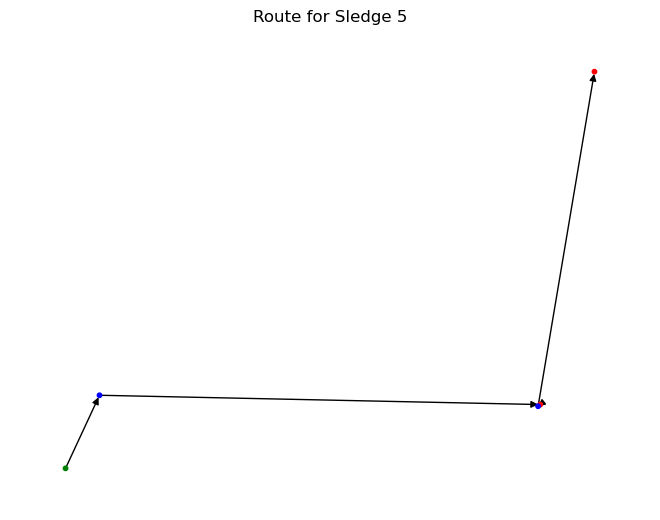

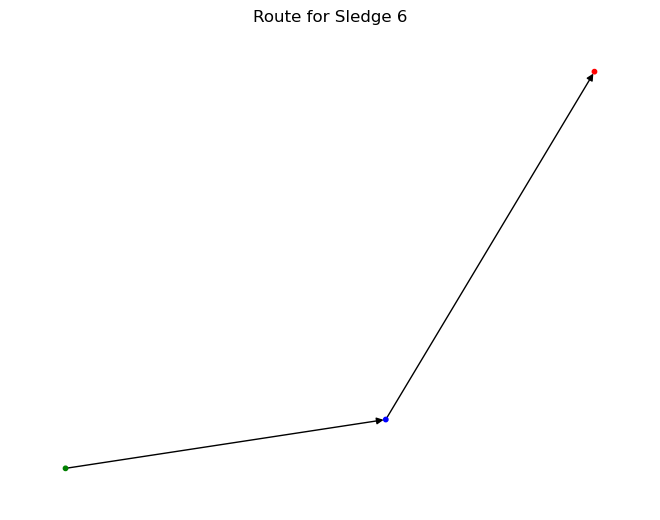

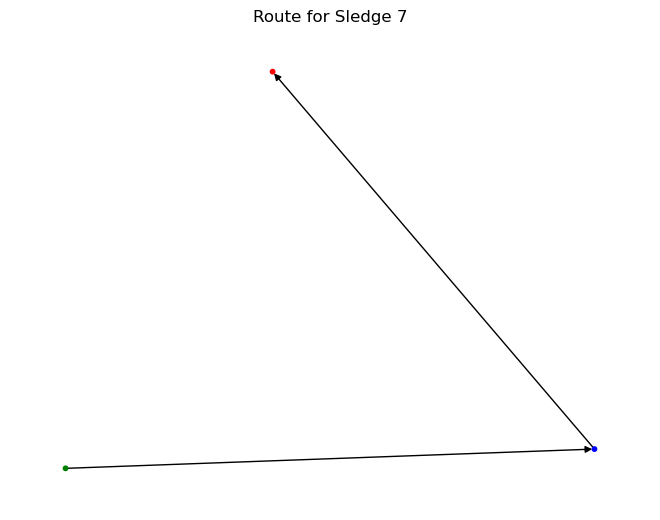

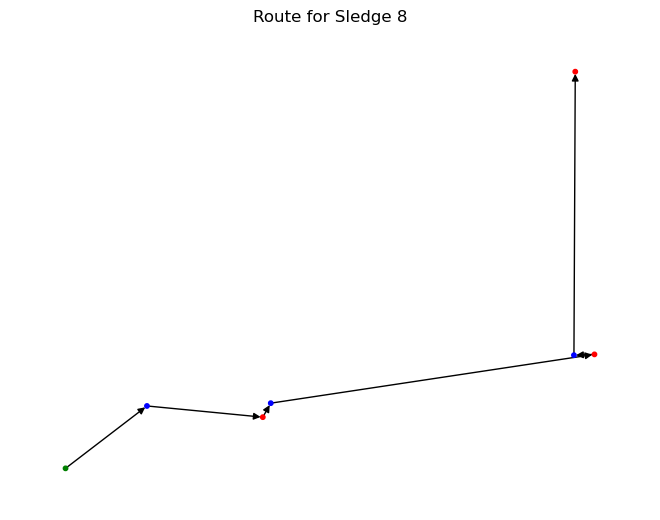

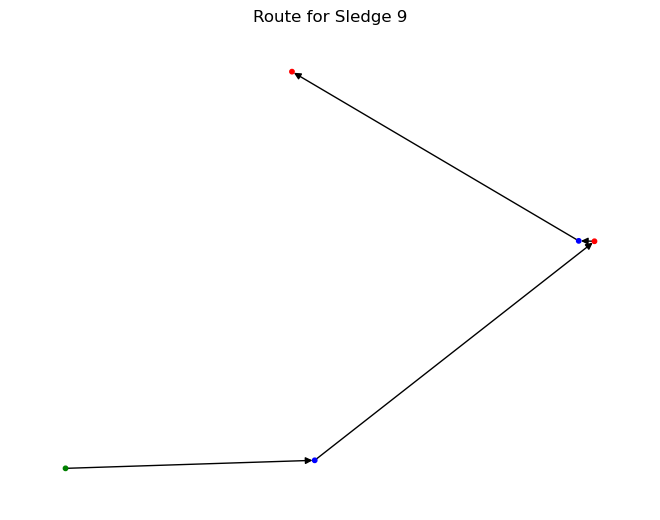

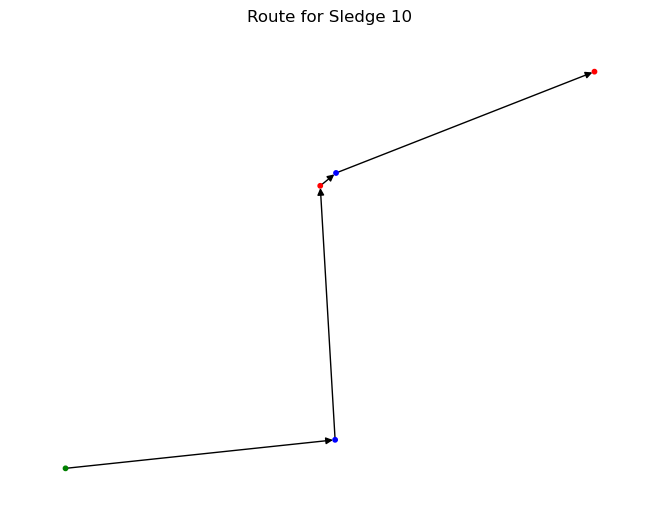

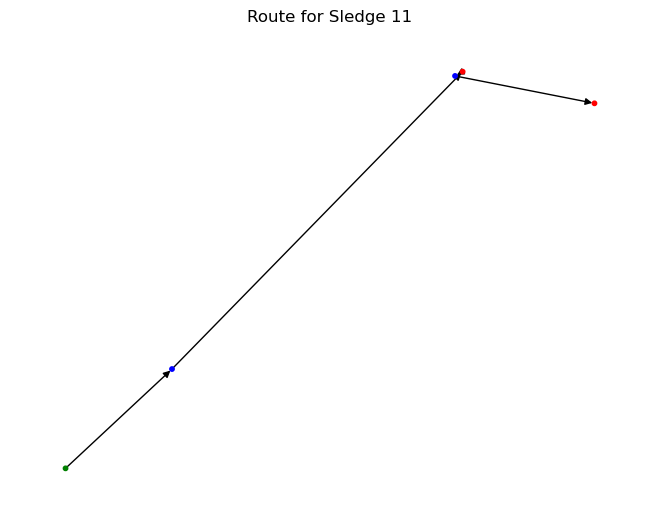

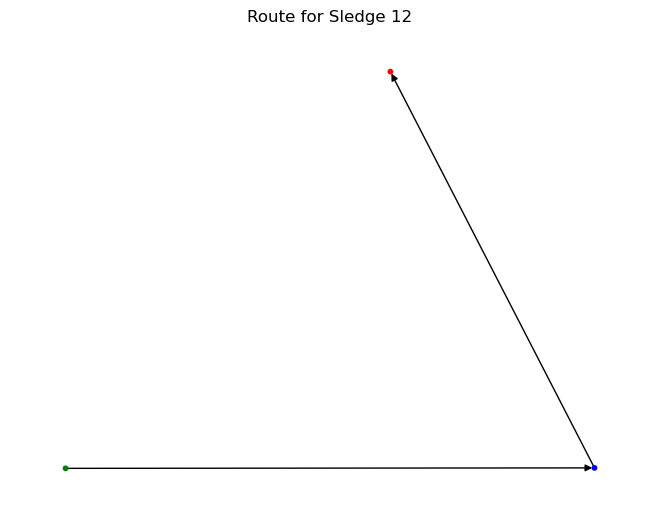

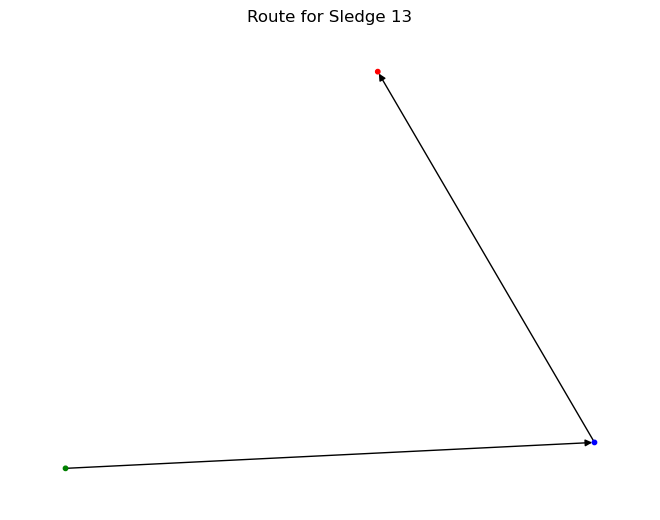

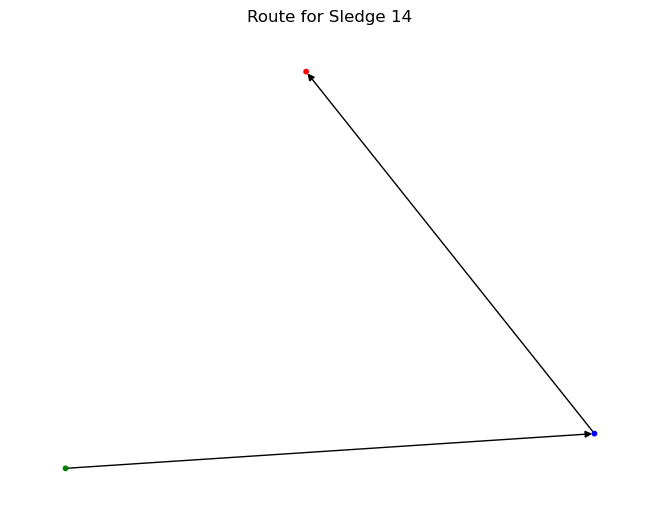

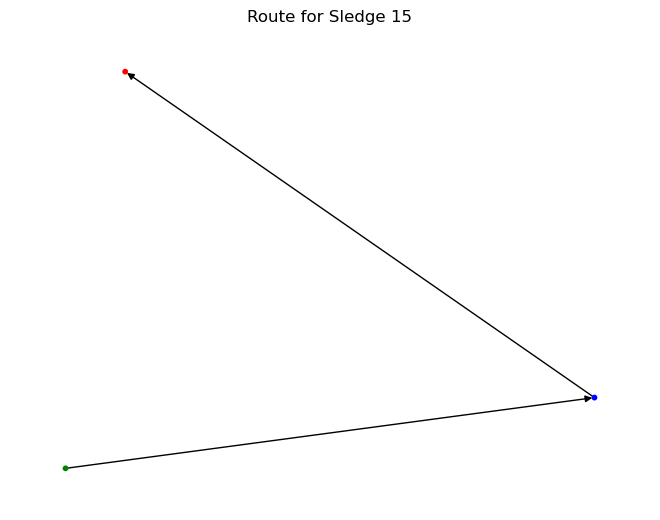

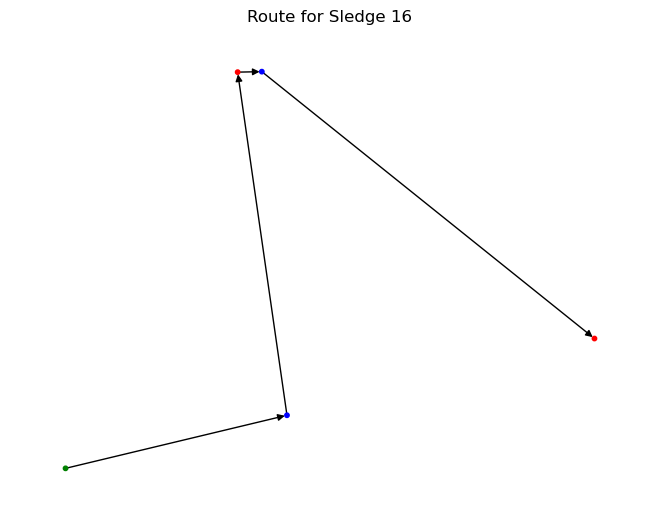

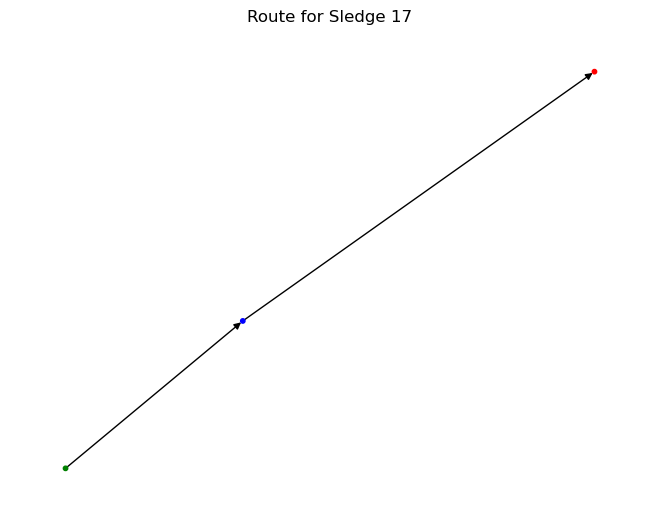

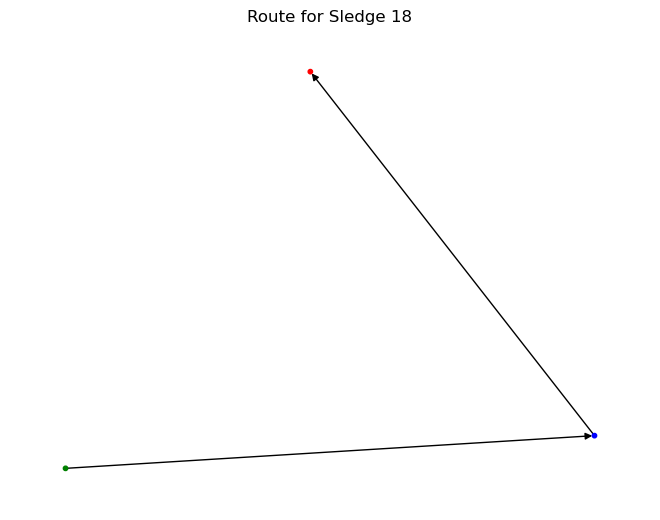

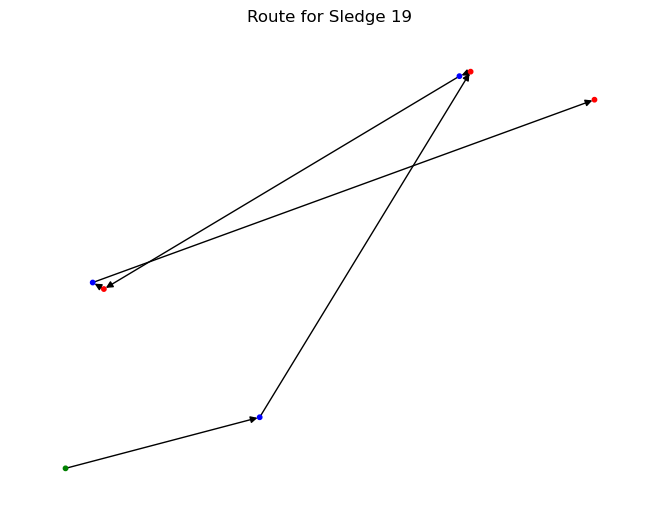

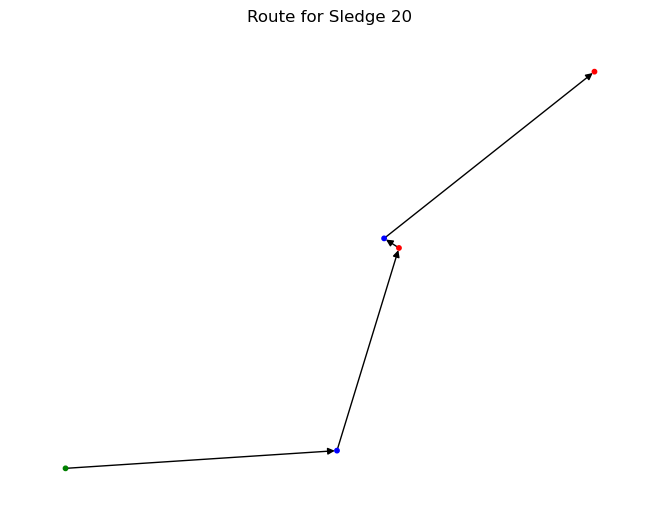

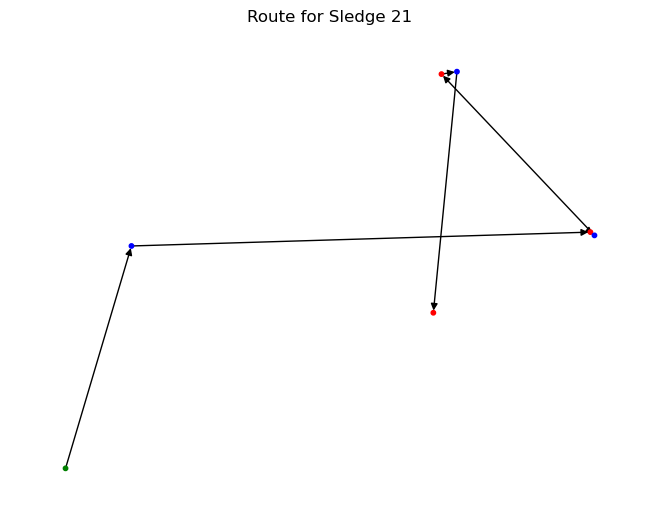

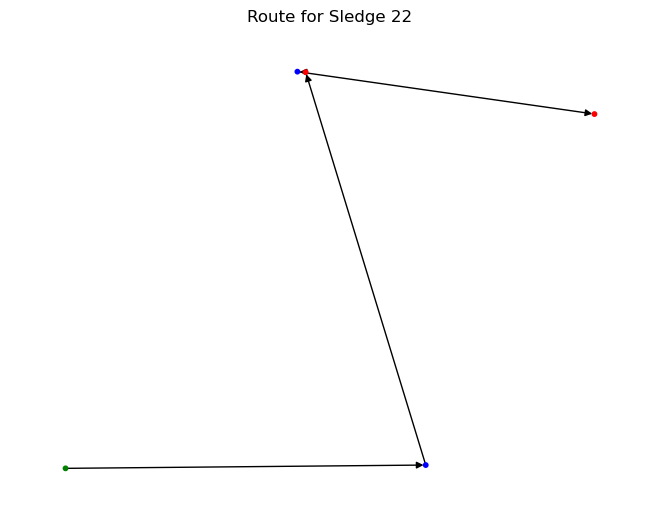

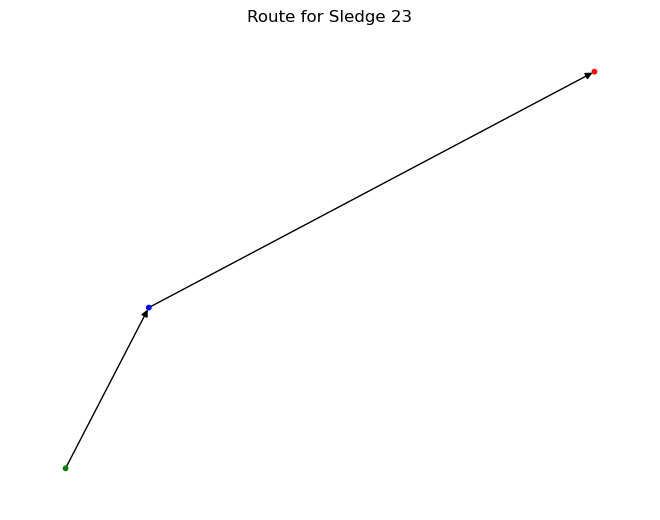

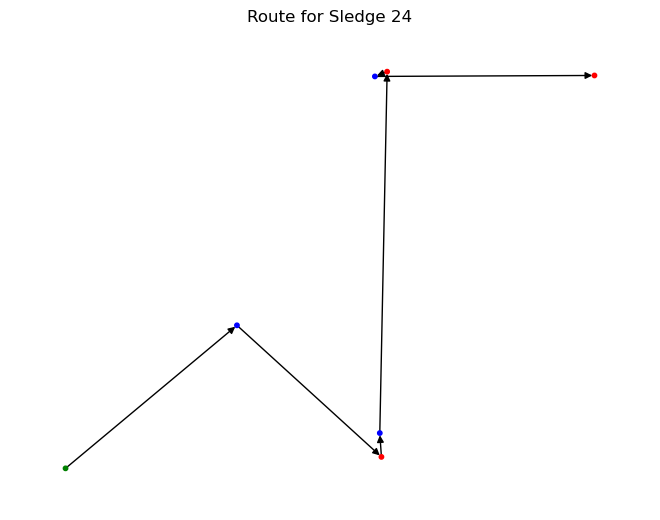

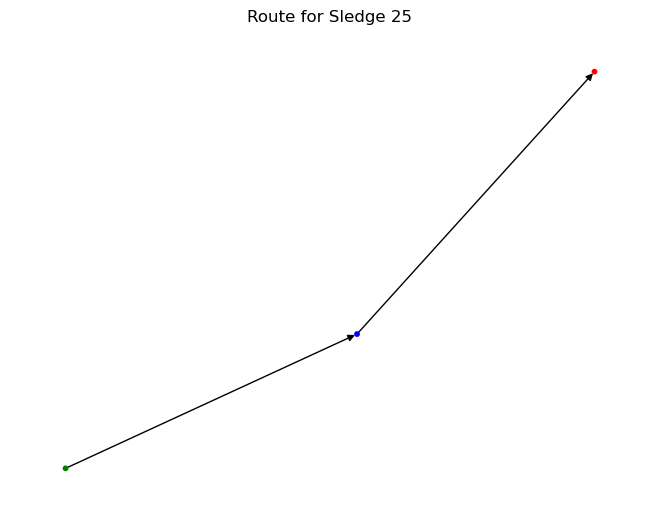

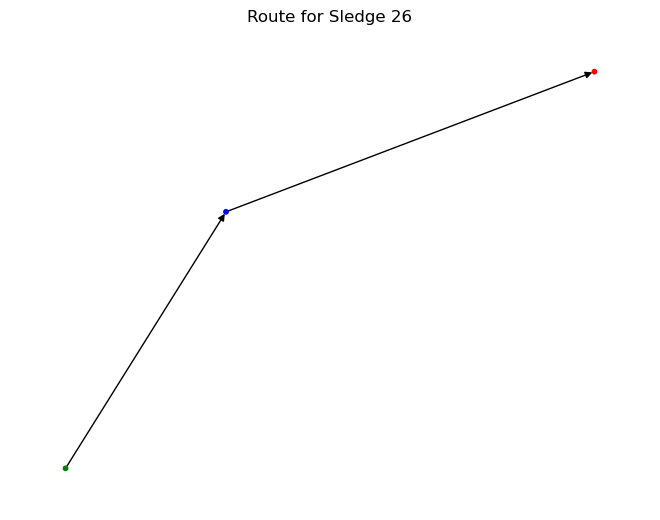

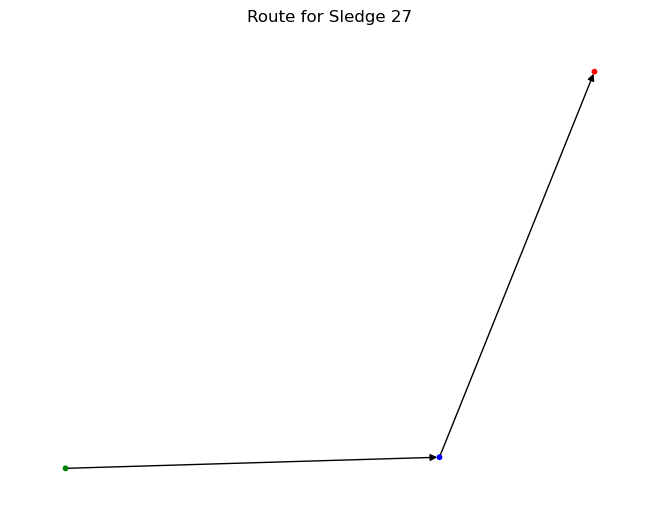

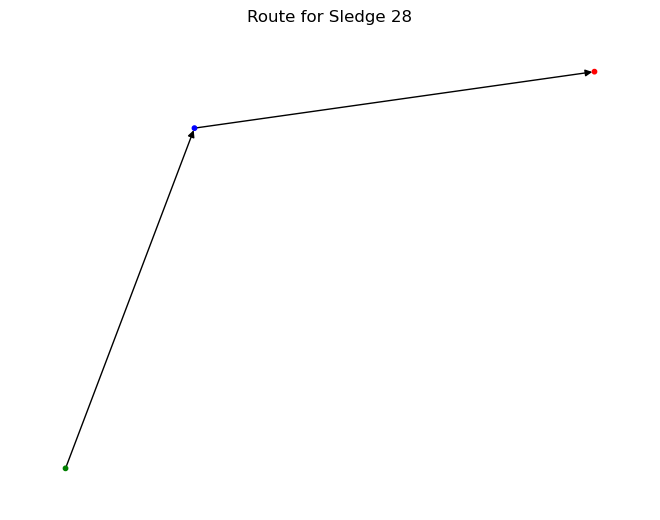

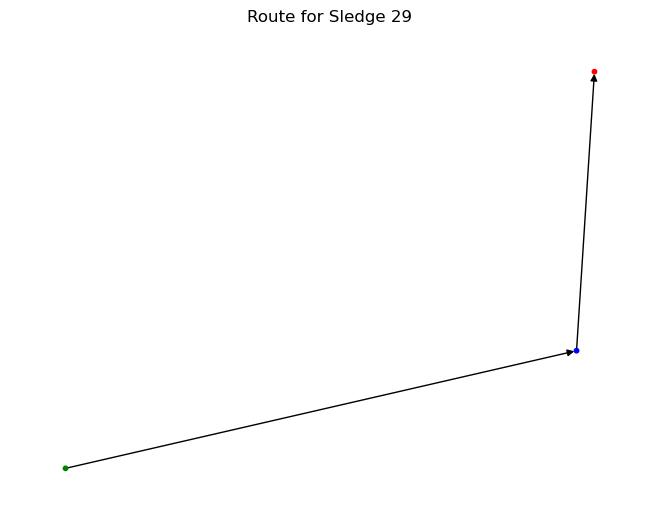

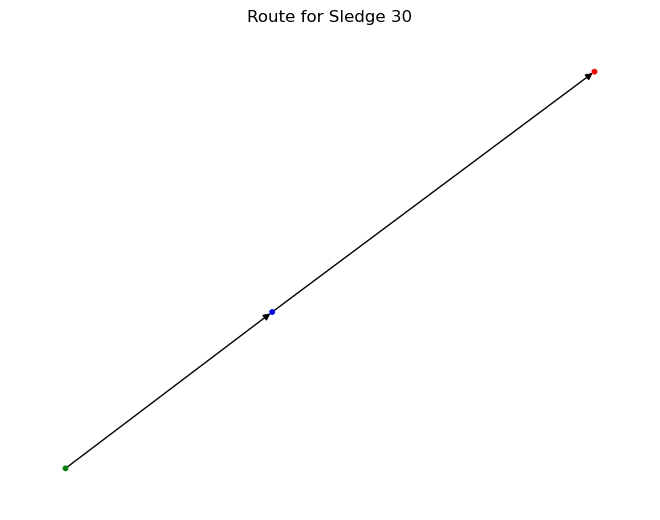

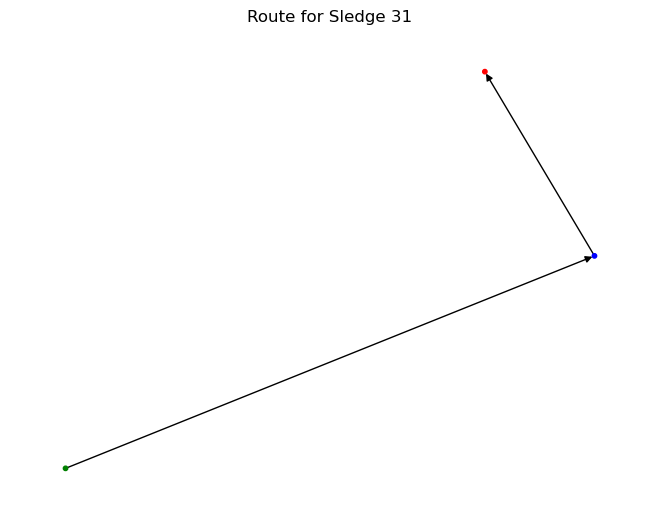

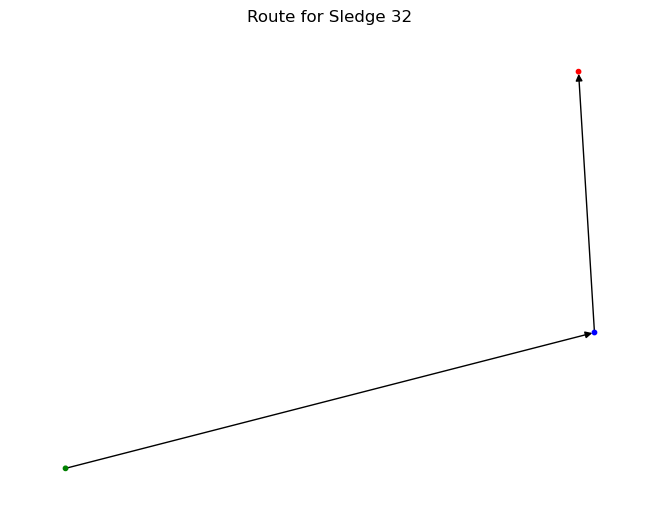

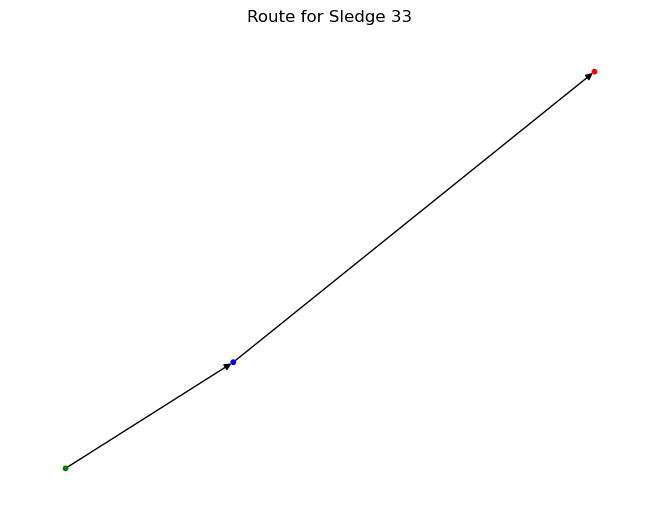

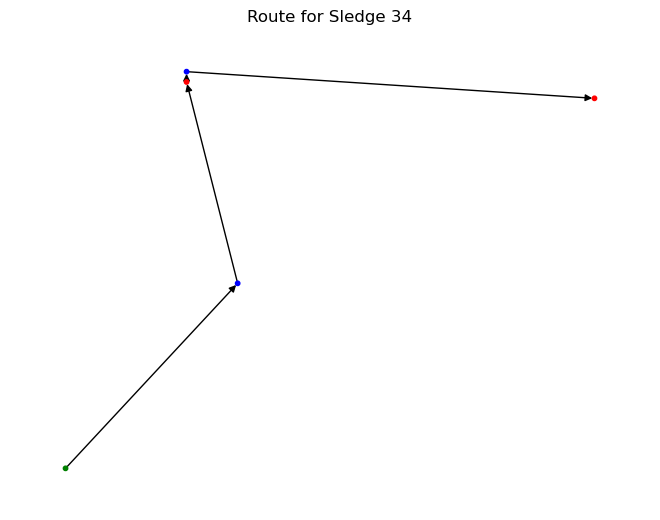

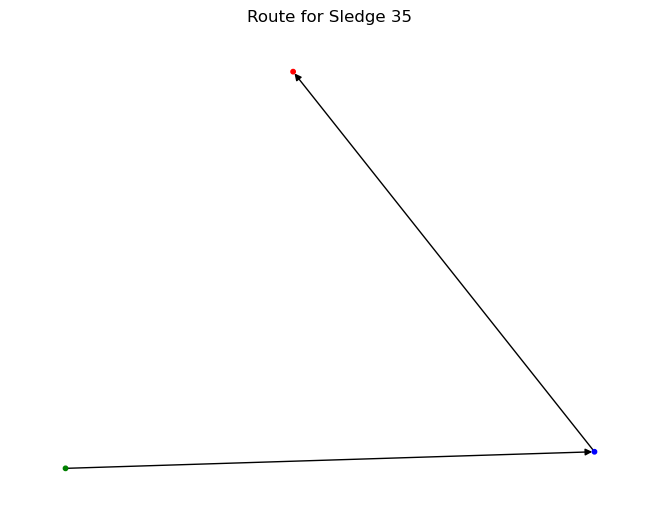

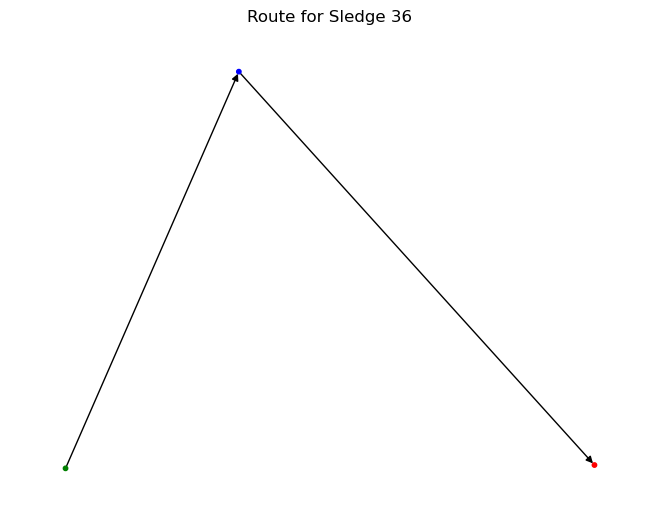

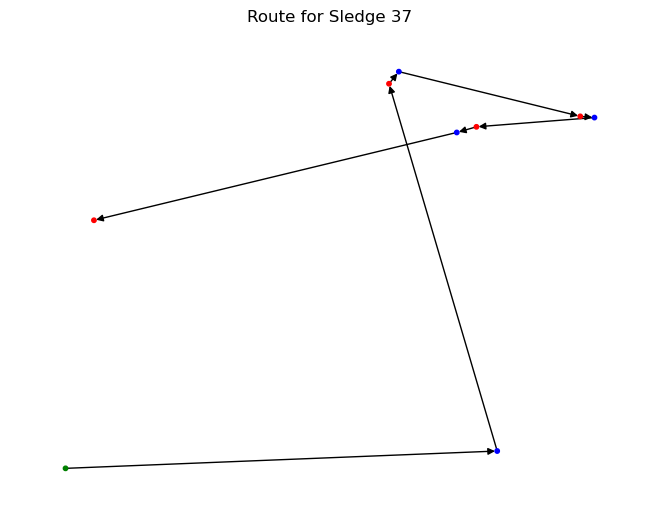

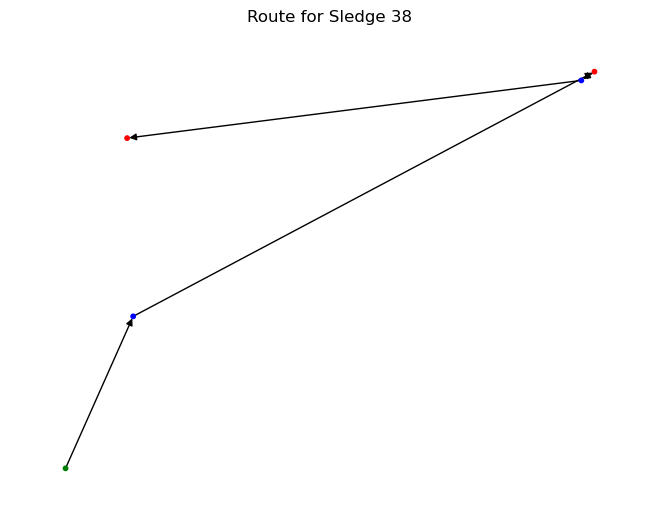

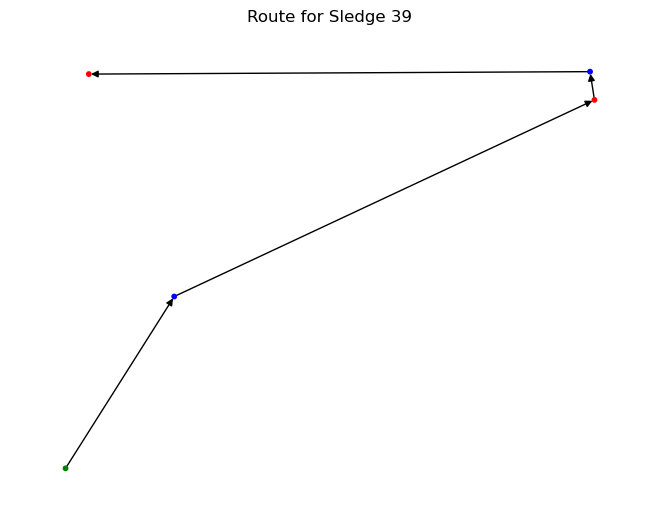

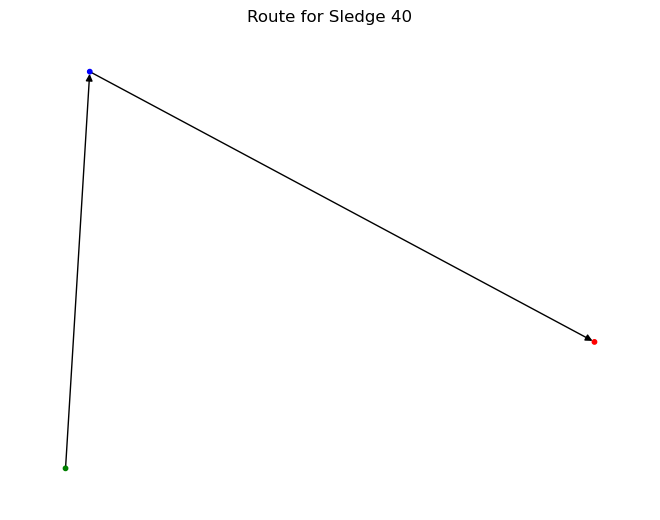

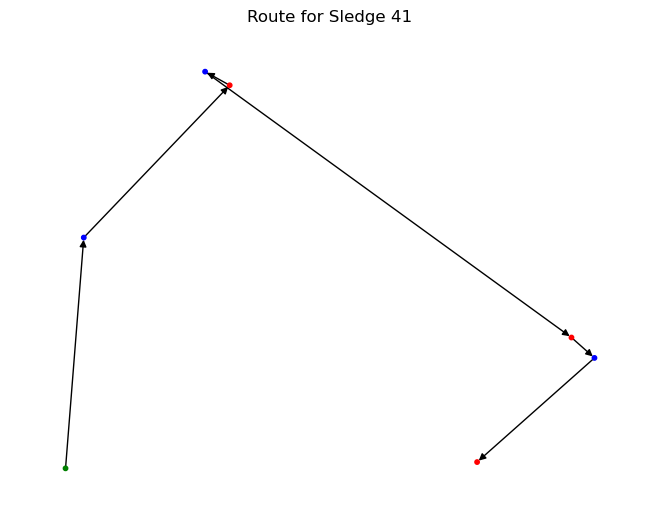

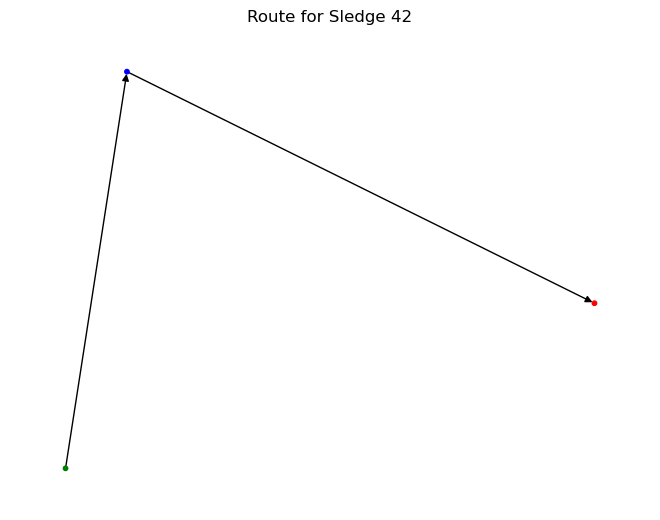

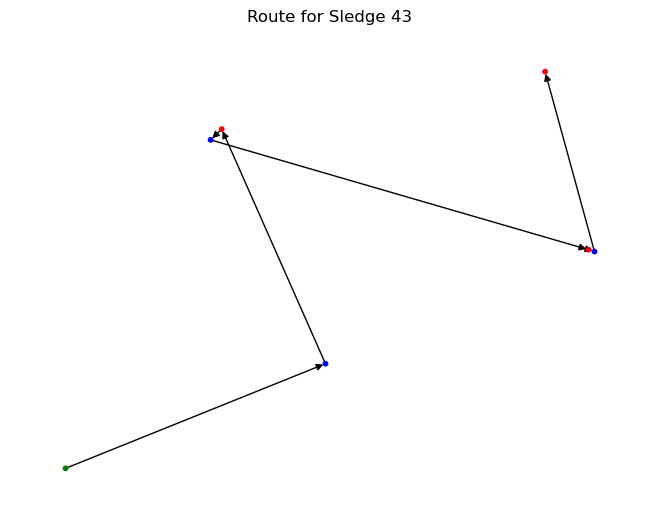

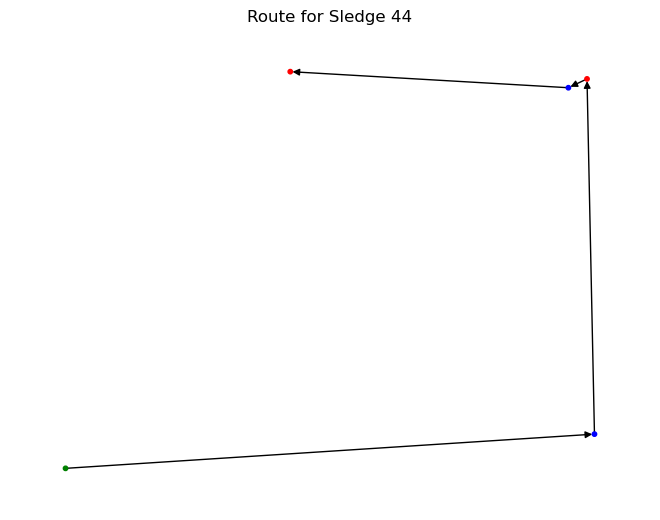

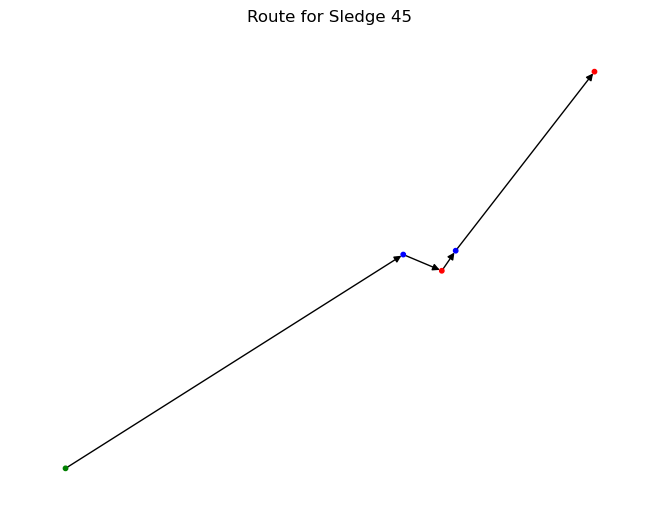

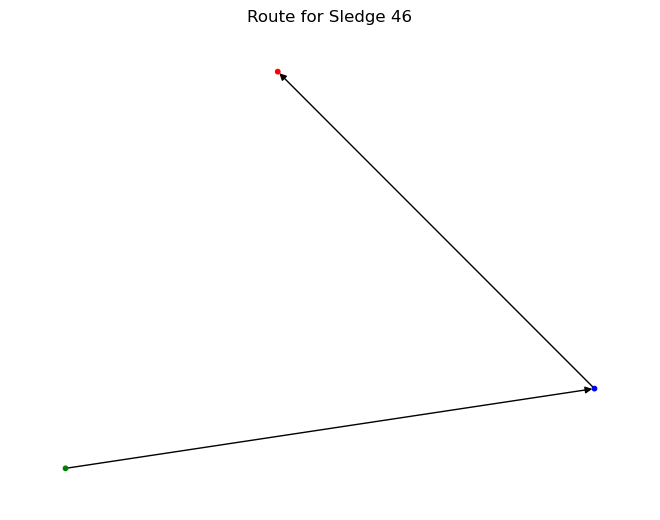

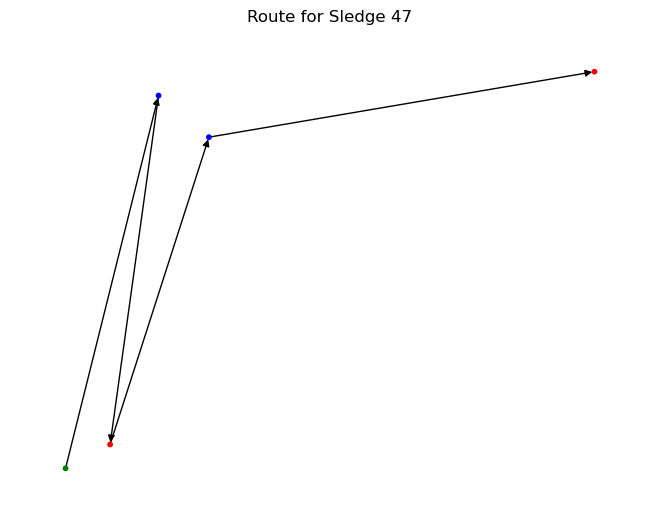

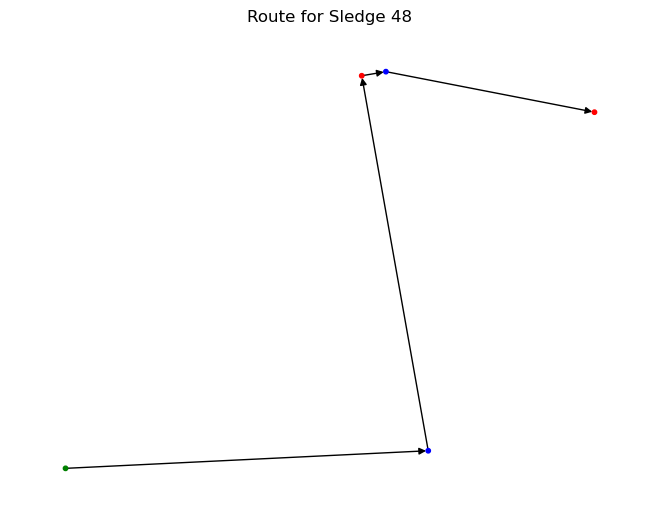

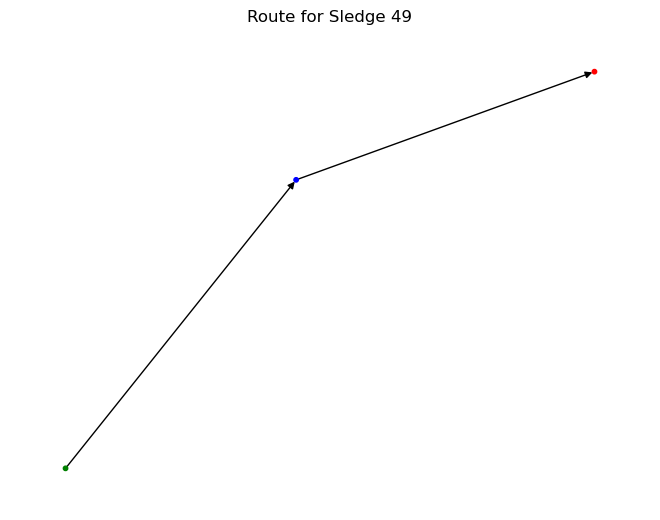

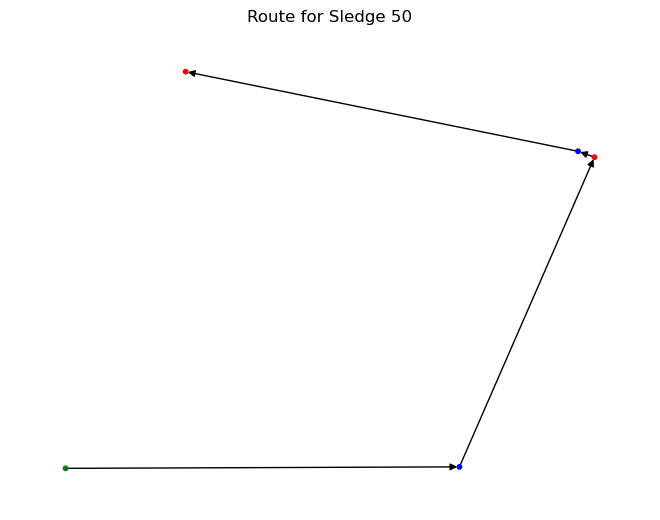

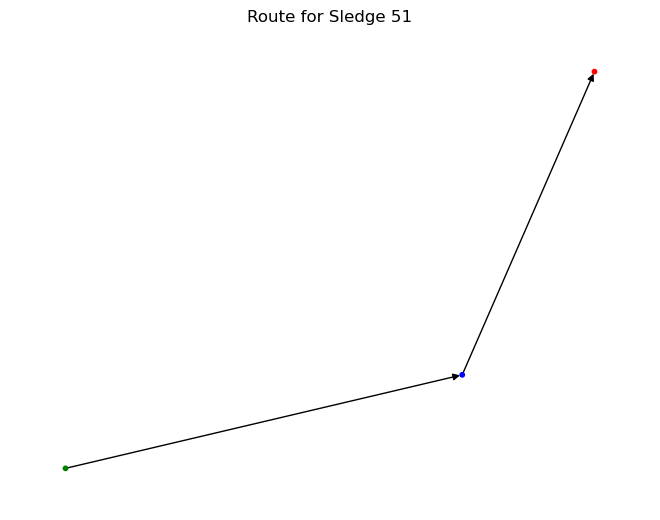

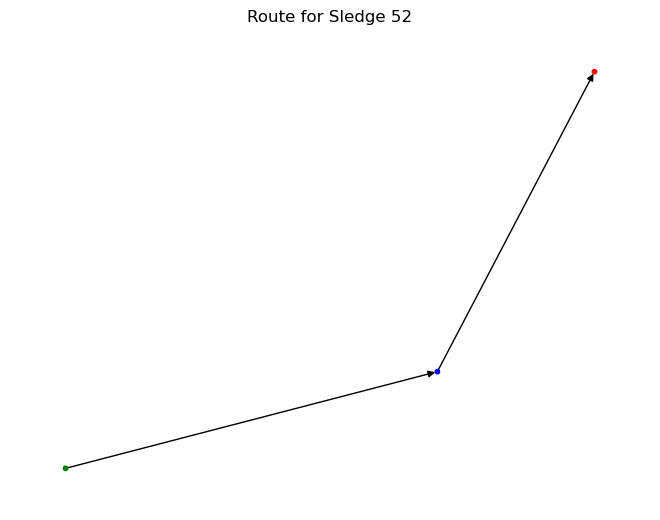

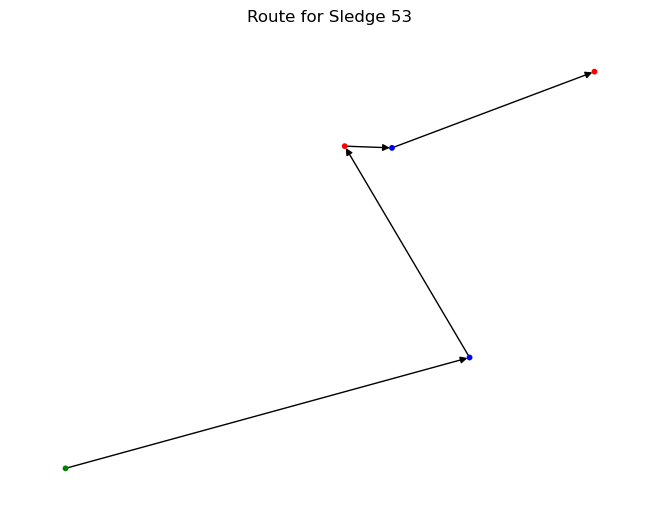

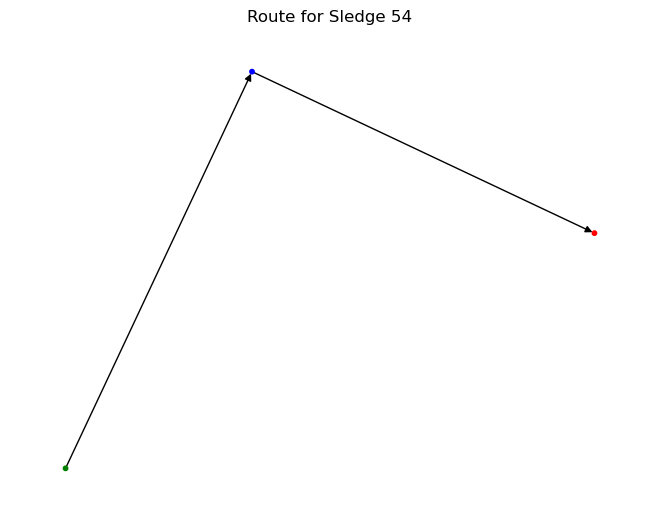

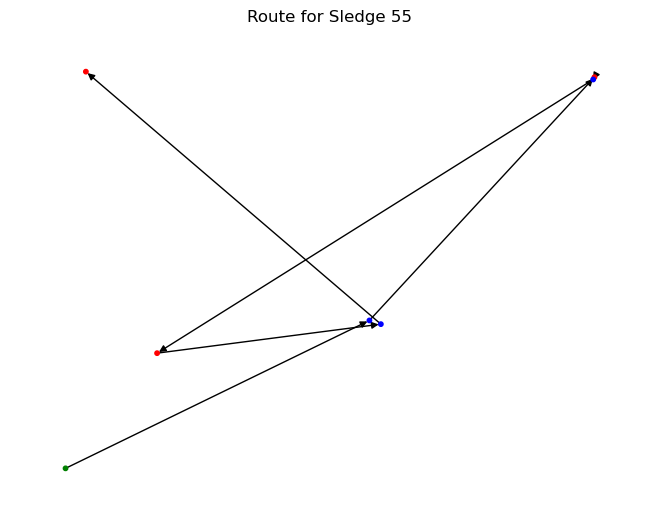

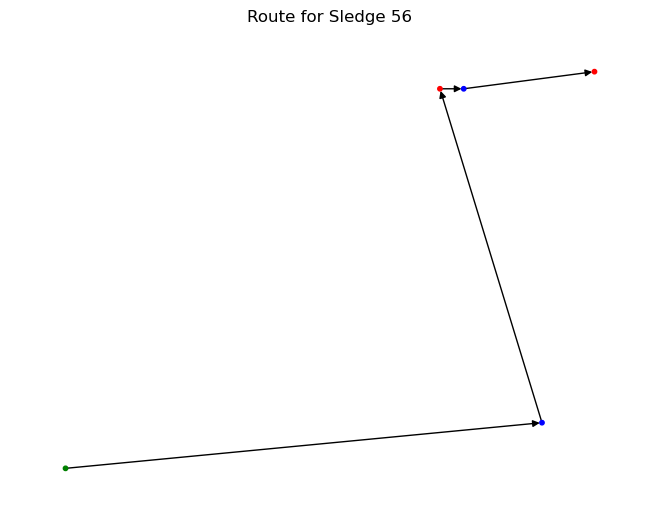

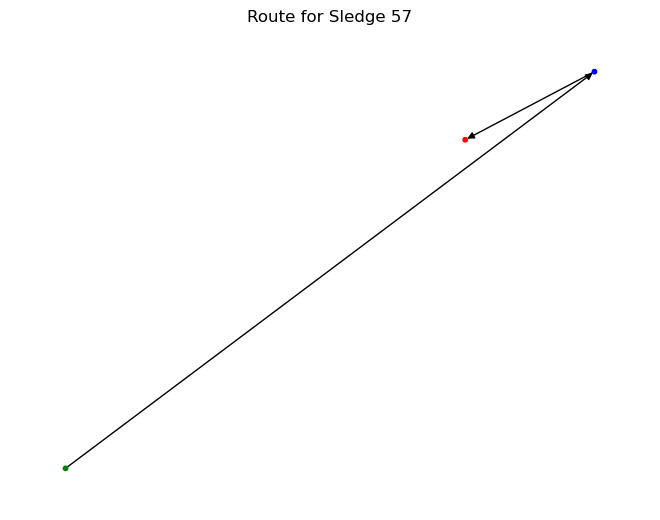

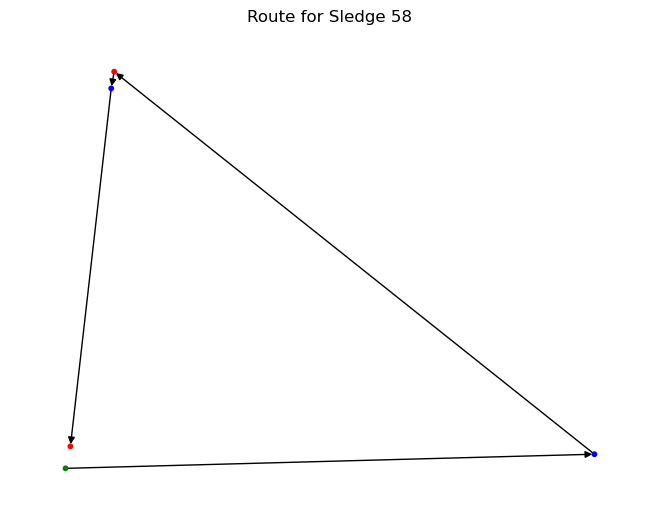

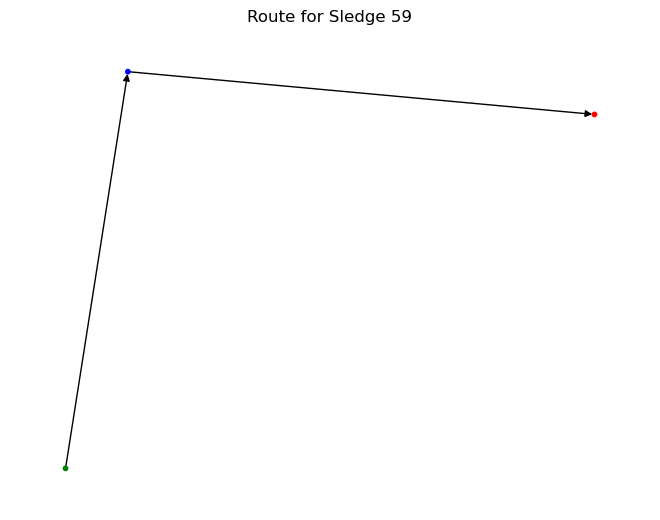

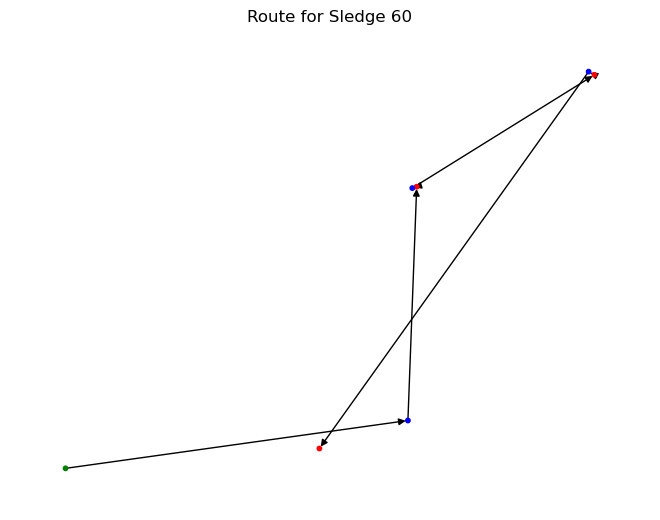

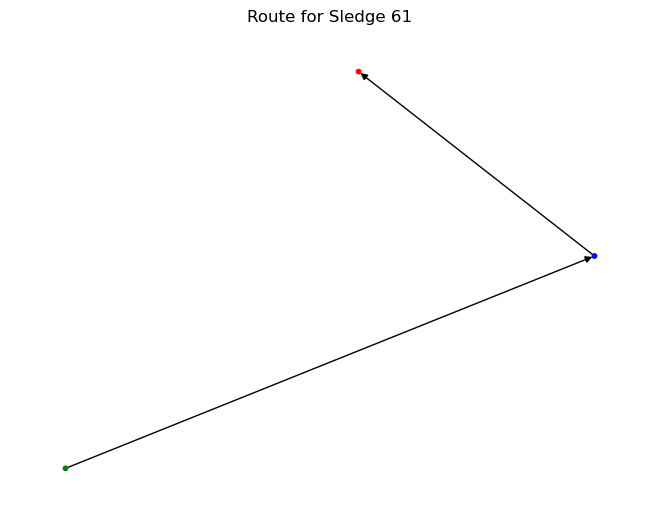

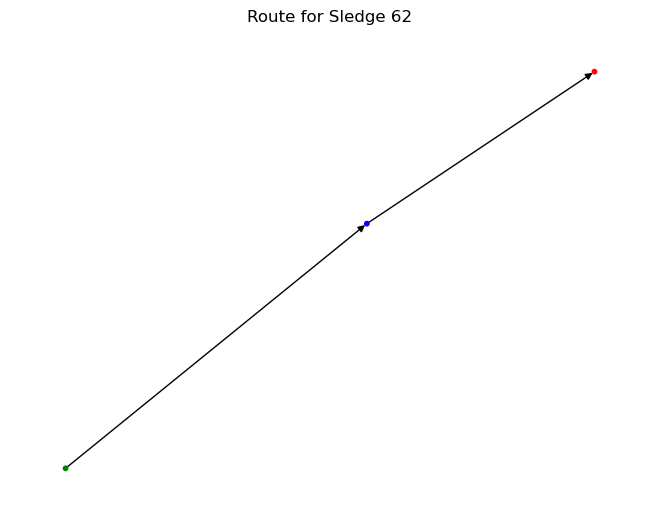

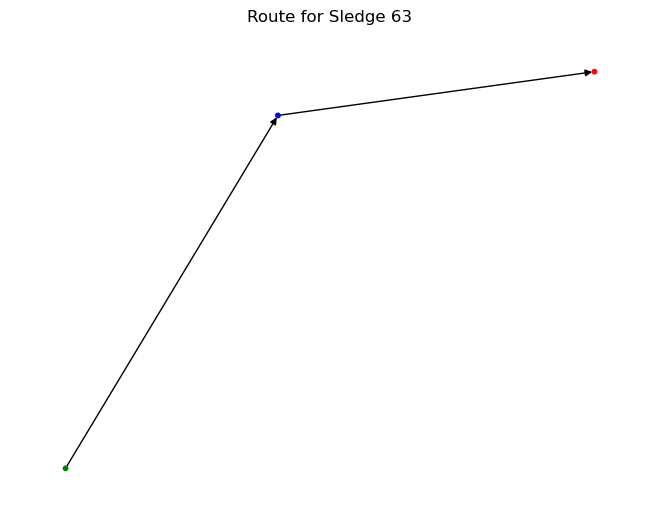

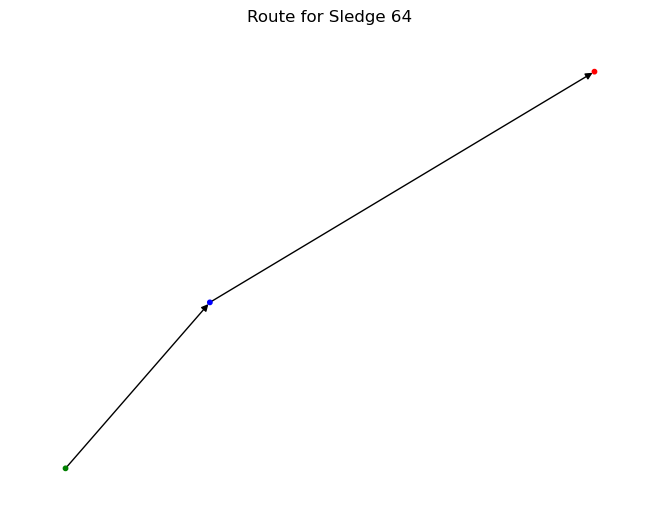

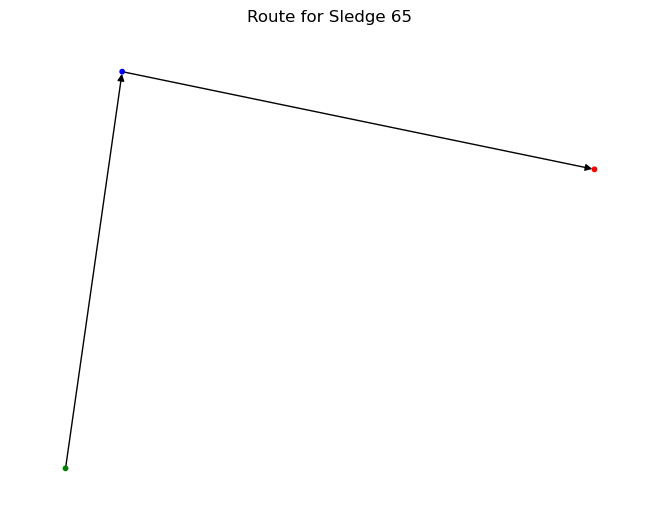

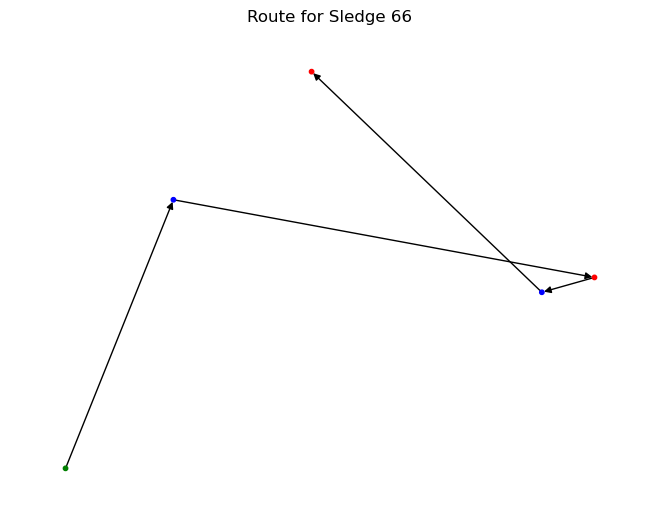

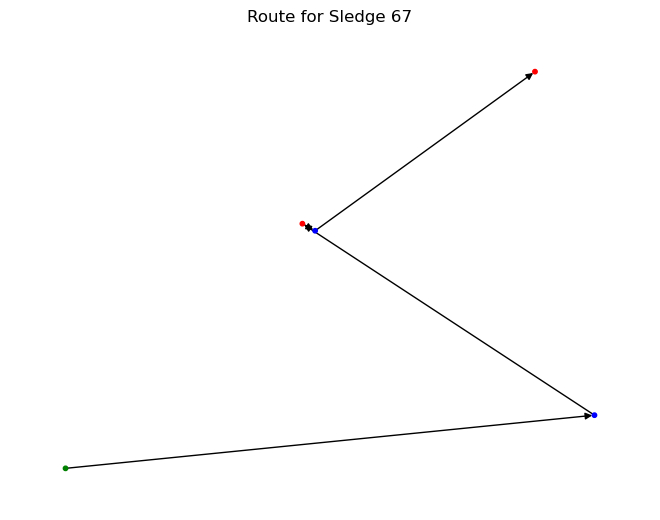

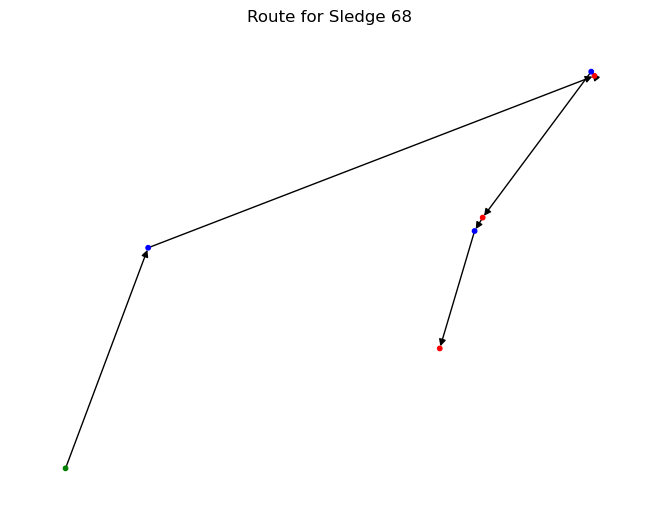

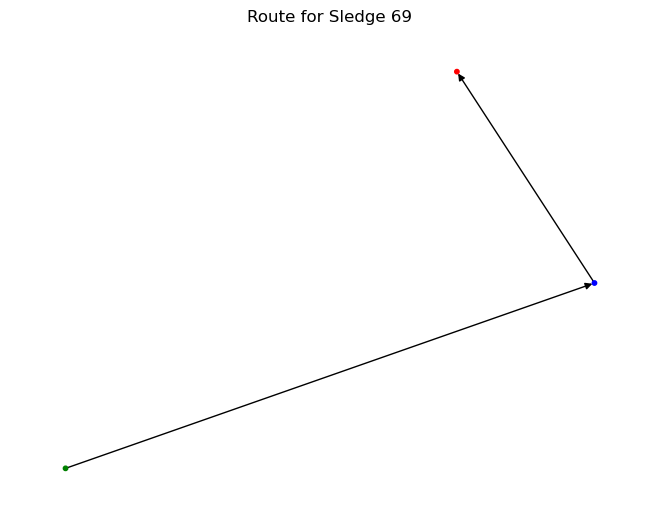

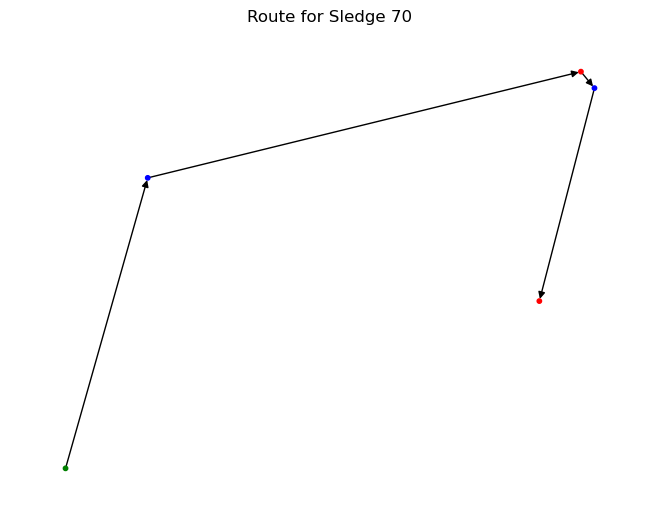

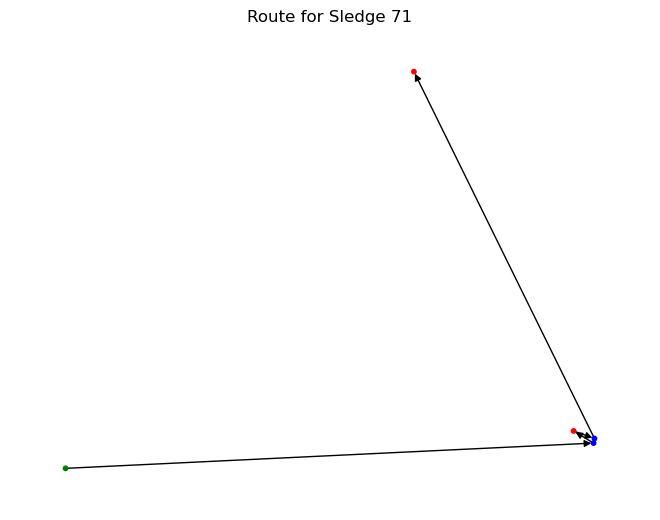

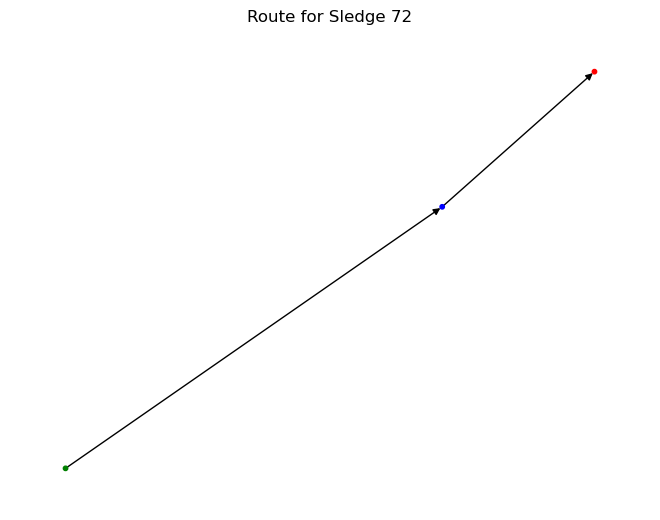

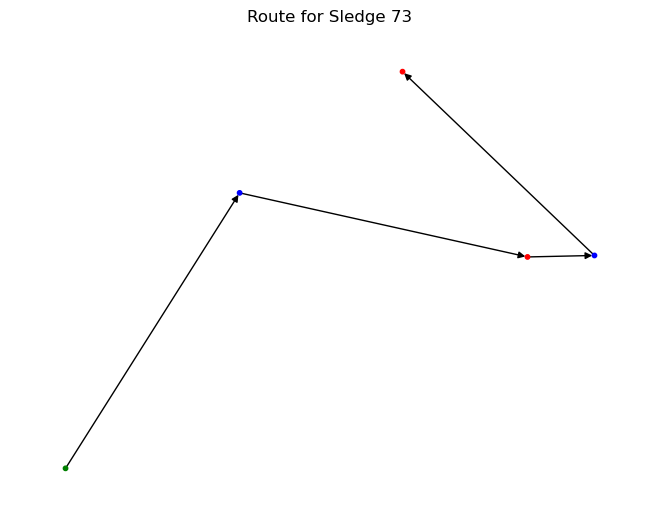

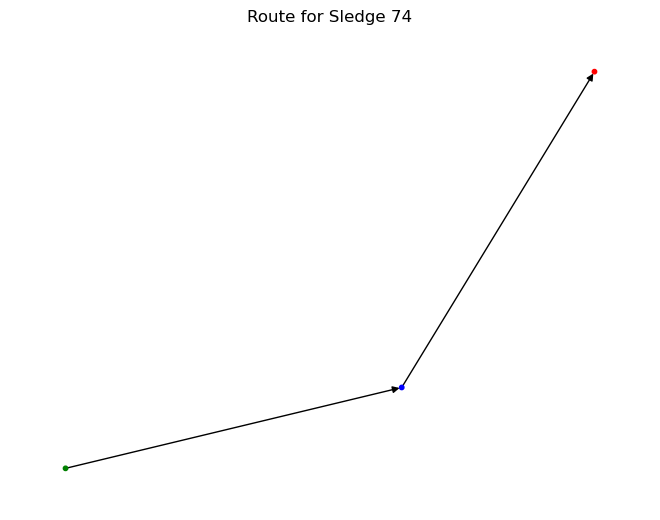

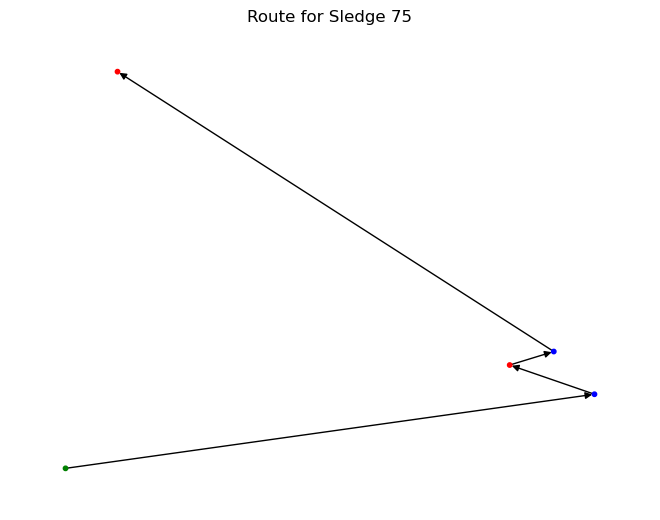

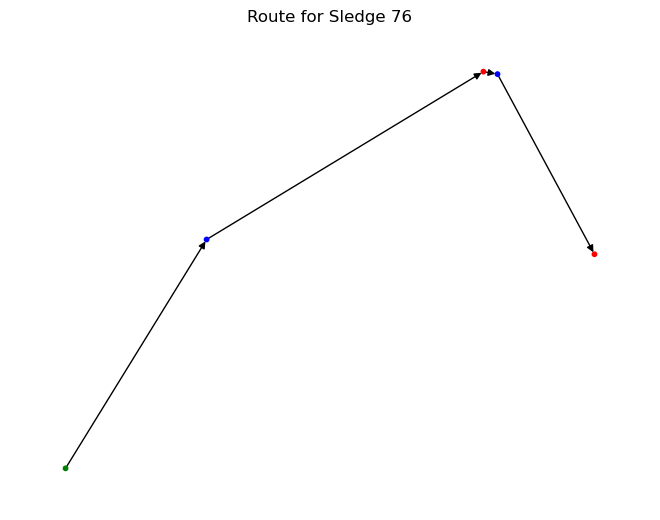

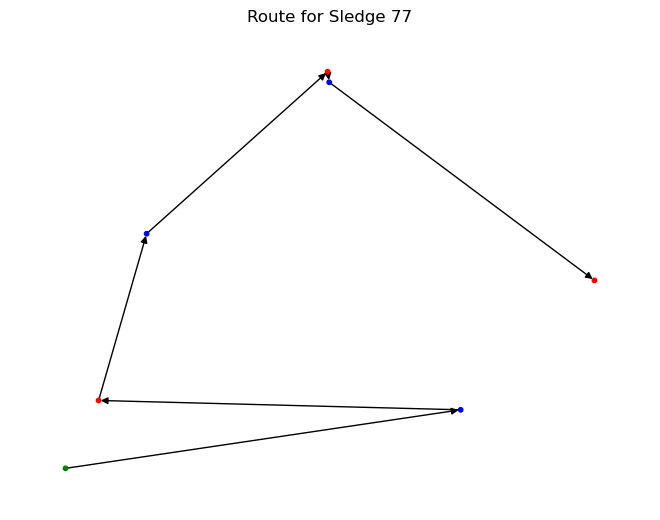

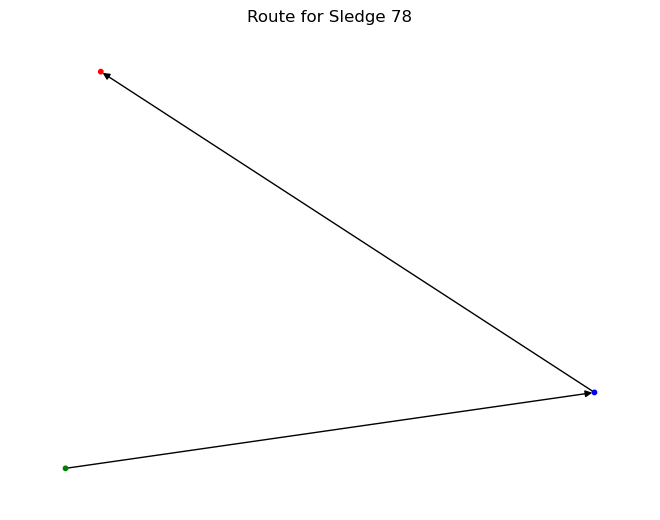

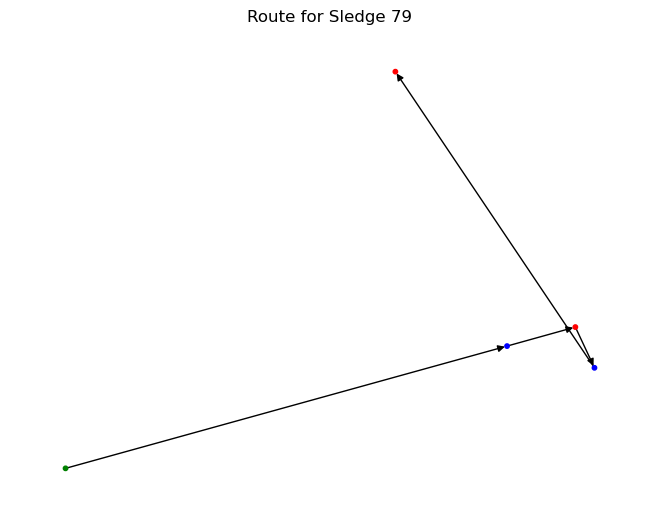

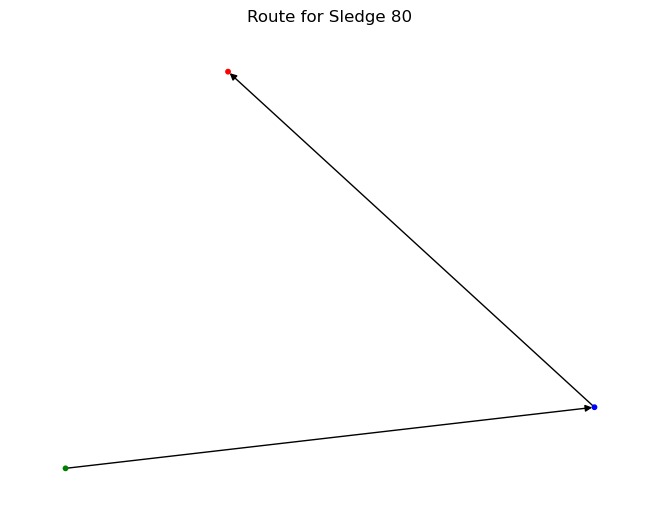

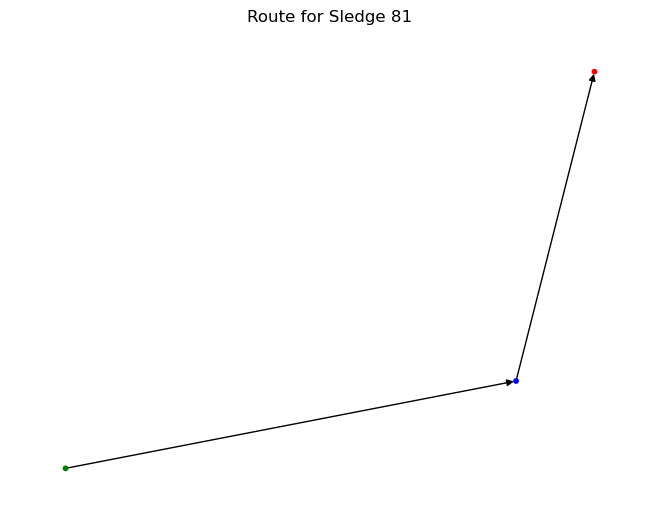

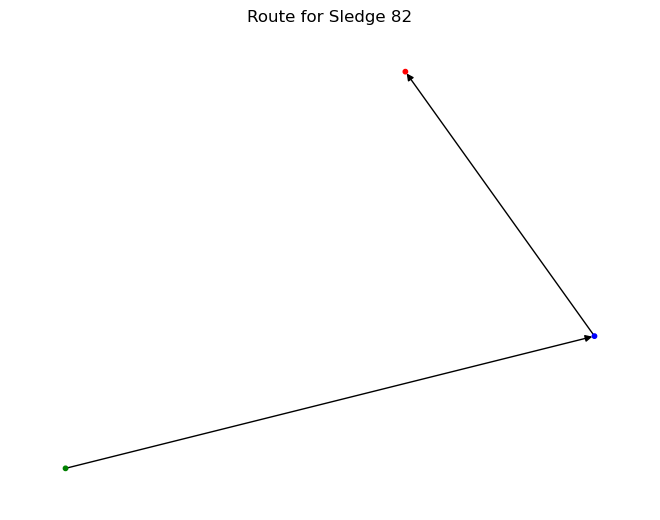

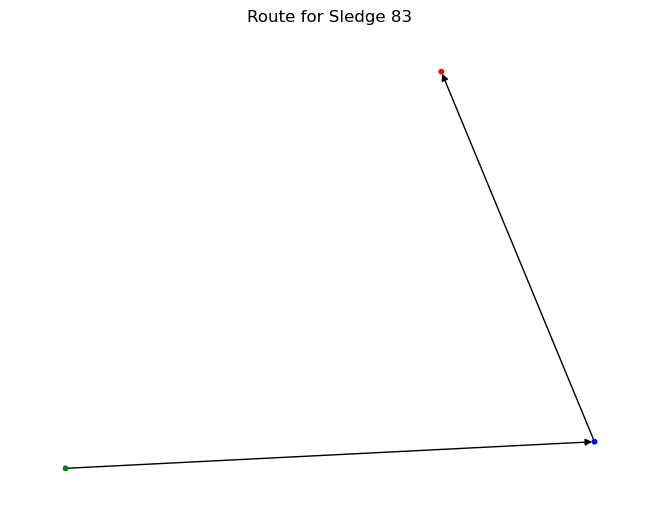

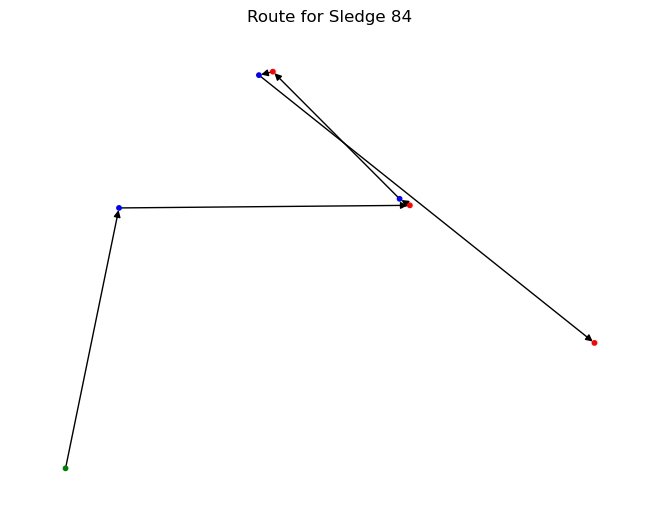

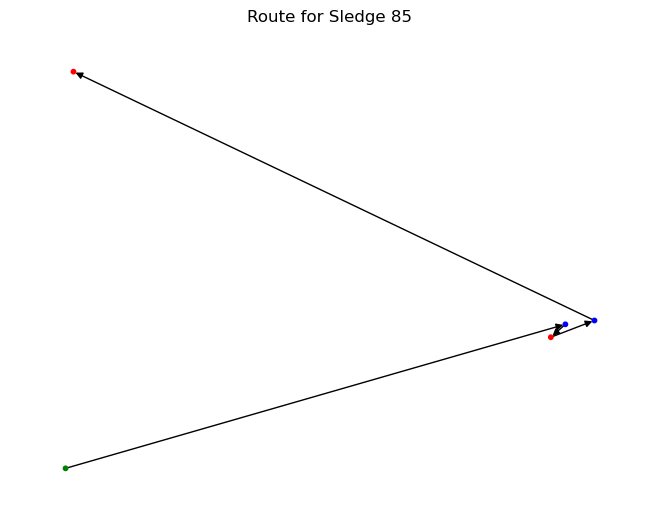

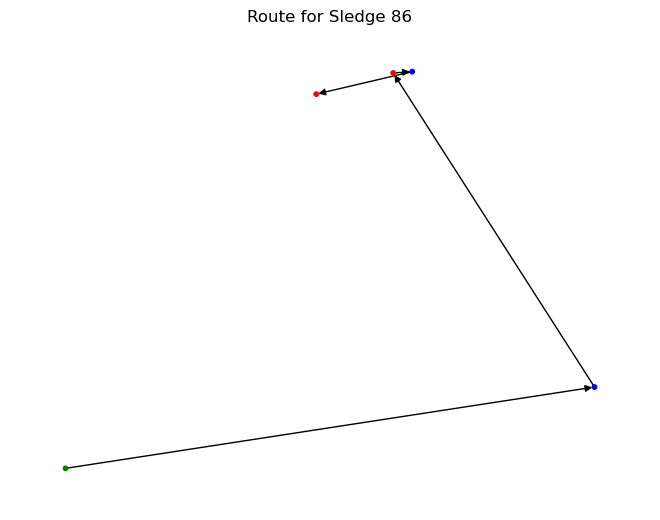

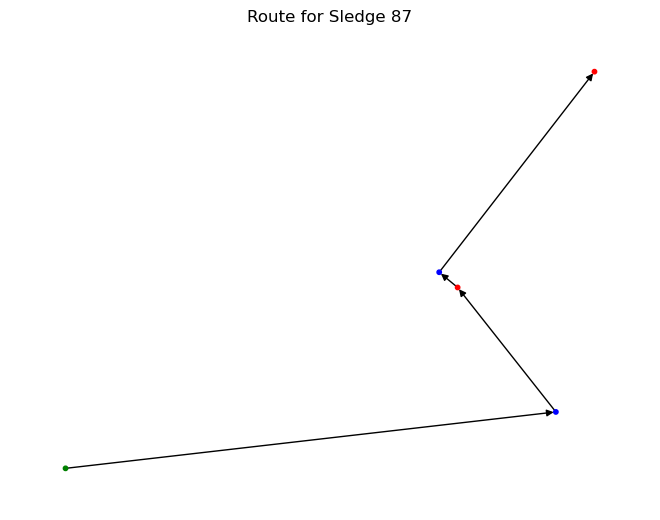

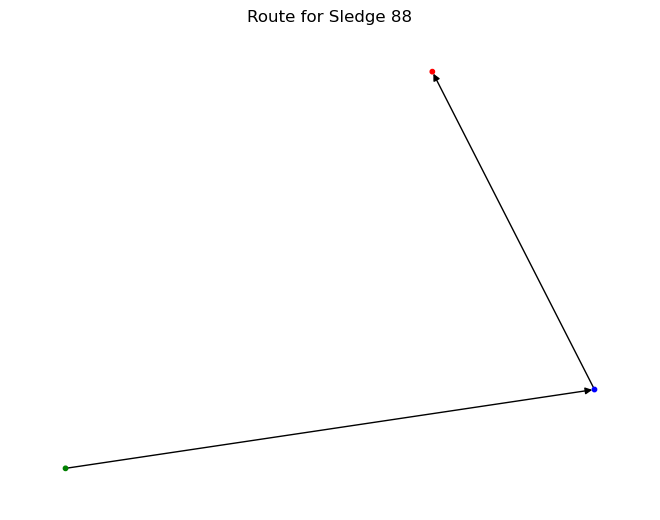

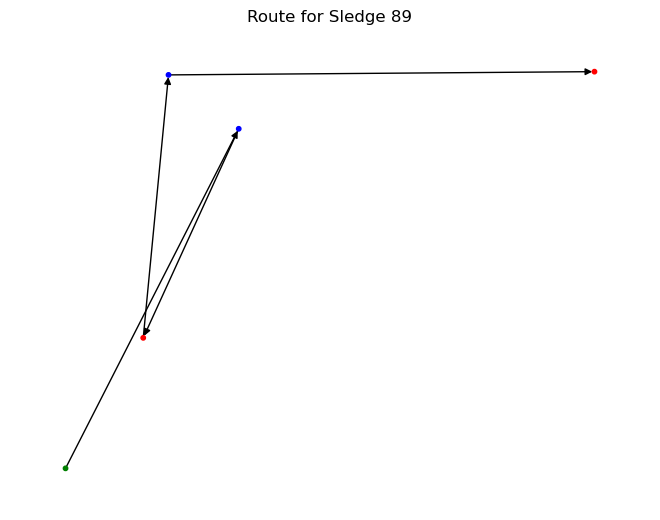

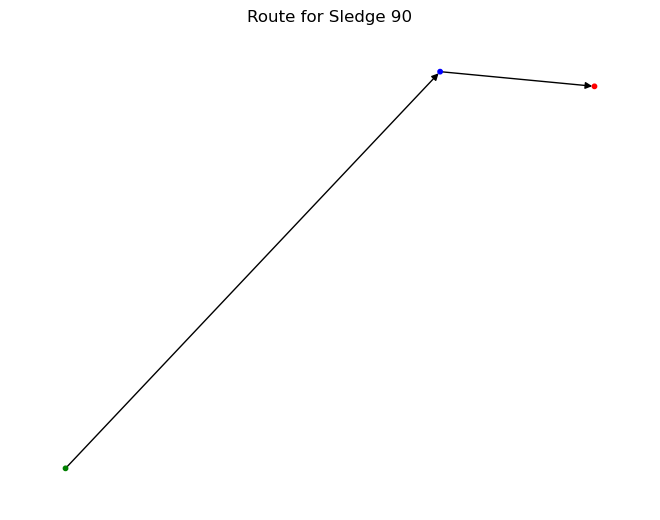

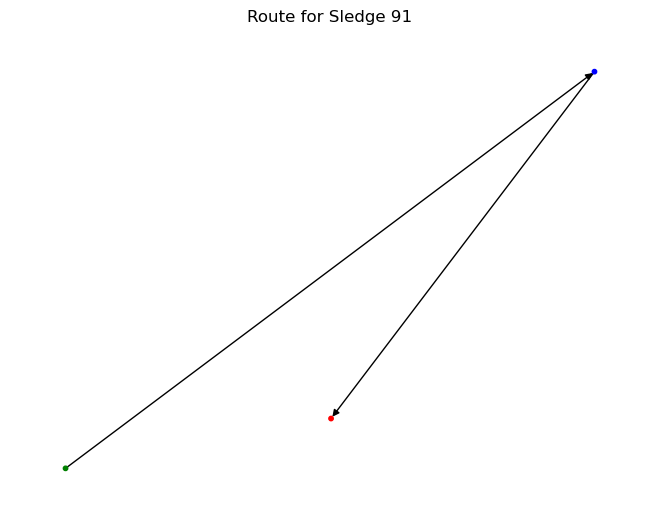

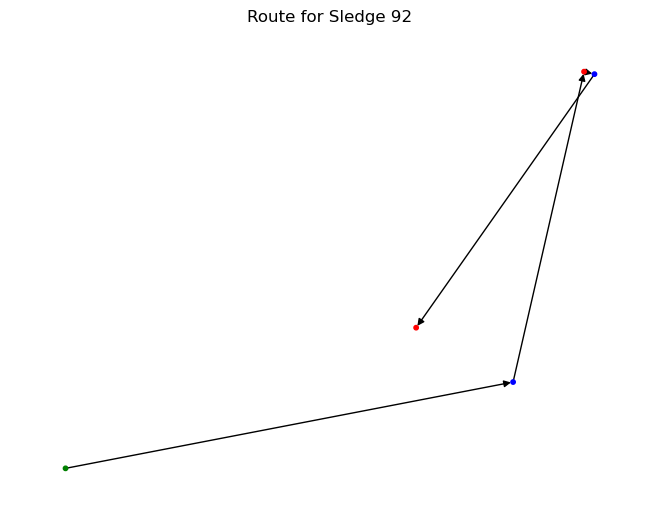

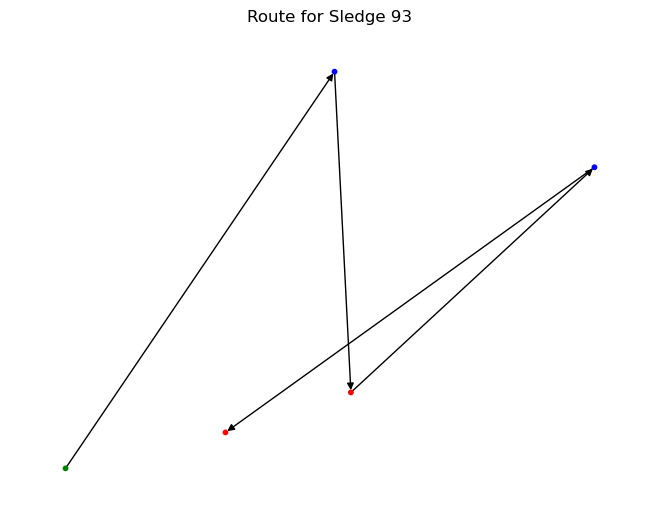

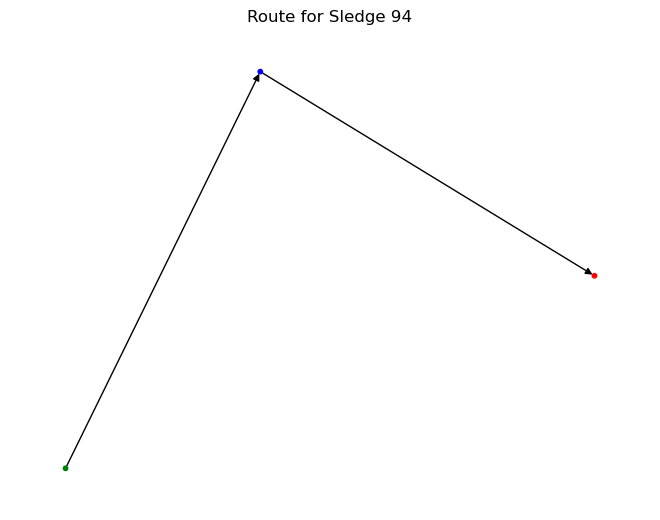

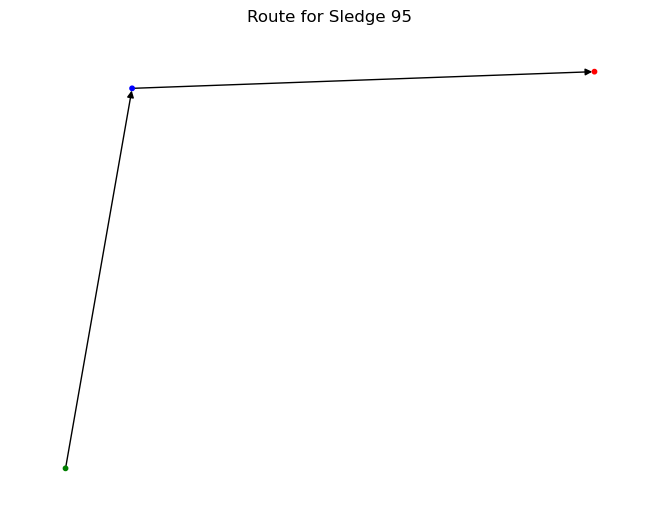

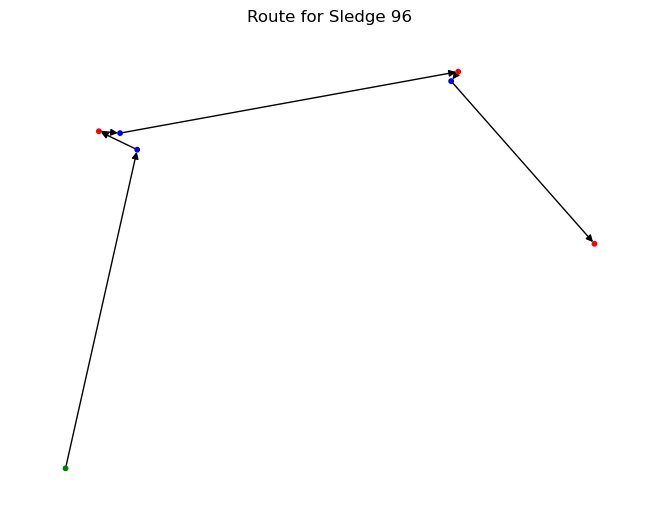

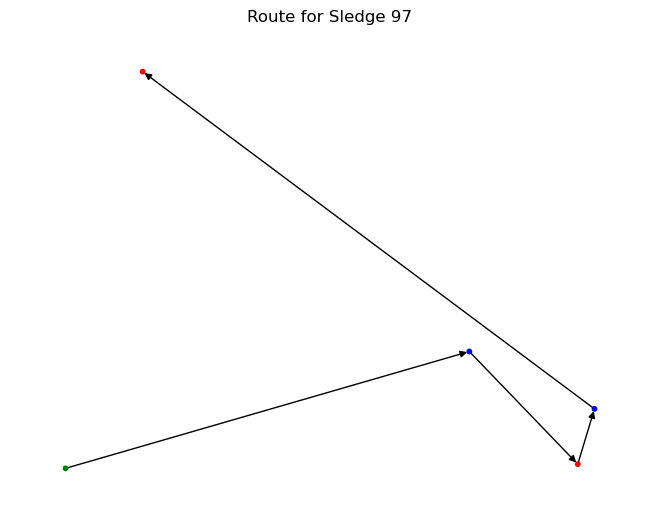

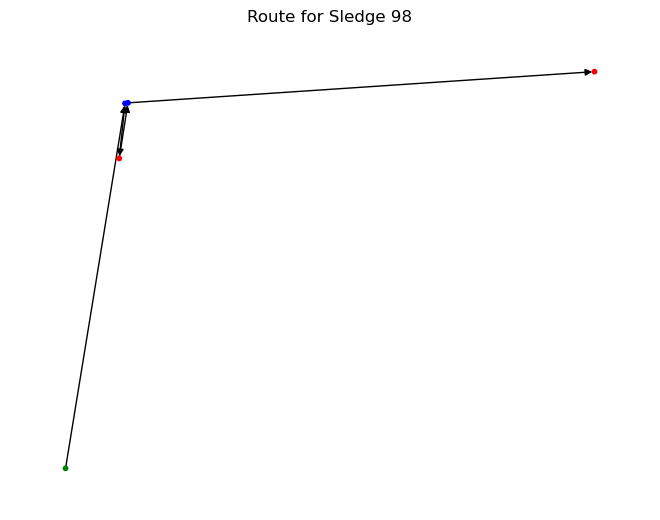

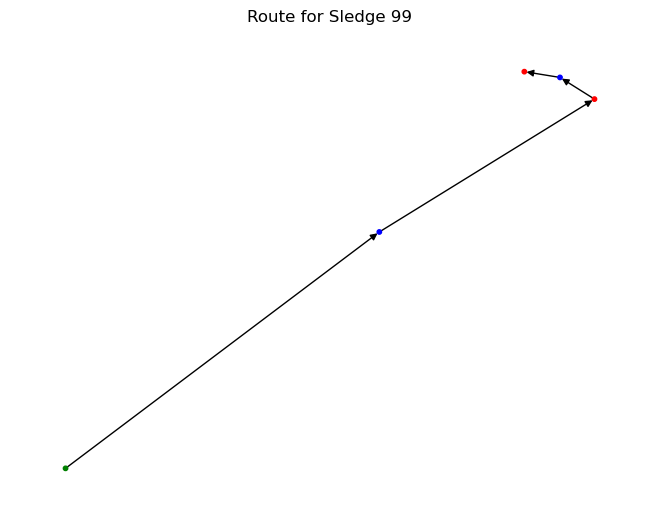

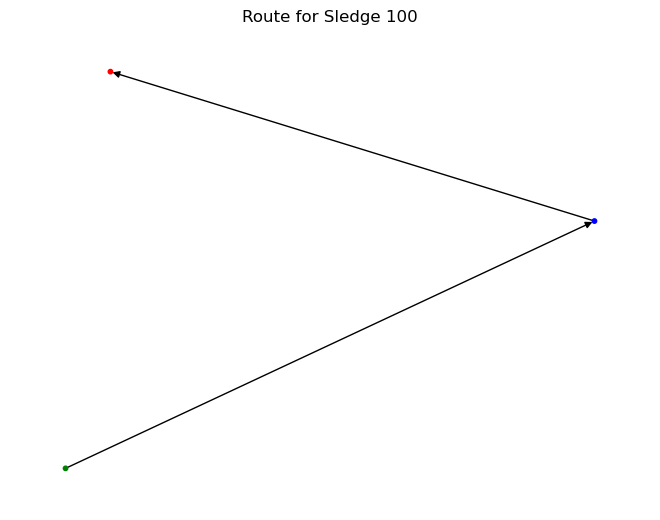

Total Score: -634071


In [10]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt



# Read the file
file_path = 'Datasets/2_Delft.txt'

# Read the general parameters line
with open(file_path, 'r') as file:
    general_params = file.readline()
    general_paramslist = general_params.split(" ")


horizontal_streets = int(general_paramslist[0])
vertical_street = int(general_paramslist[1])
no_sledges = int(general_paramslist[2])
no_presents = int(general_paramslist[3])
bonus_per_ride = int(general_paramslist[4])
no_steps = int(general_paramslist[5]) 



class Present:
    def __init__(self, a, b, x, y, s, f,n):
        self.starthor = a
        self.startver = b
        self.finhor = x
        self.finver = y
        self.devtime = s
        self.fintime = f
        self.nr = n

class Sledge:
    def __init__(self):
        self.no_pres_deliv = 0
        self.no_steps_taken = 0
        self.pres_deliv = []
        self.current_hor = 0
        self.current_ver = 0

    def add_present(self, p):
        self.no_pres_deliv += 1
        self.no_steps_taken += (abs(self.current_hor - p.starthor) + abs(self.current_ver - p.startver) + 
                                abs(p.starthor - p.finhor) + abs(p.startver - p.finver))
        self.pres_deliv.append(p)
        self.current_hor, self.current_ver = p.finhor, p.finver


def nearest_neighbor_route(df, sledges, max_steps):
    unvisited = [Present(row['Start_Horizontal'], row['Start_Vertical'], row['Finish_Horizontal'], 
                         row['Finish_Vertical'], row['Earliest_Start'], row['Latest_Finish'],index) for index, row in df.iterrows()]

    for sledge in sledges:
        steps_taken = 0  # Initialize steps taken for each sledge
        while unvisited:
            nearest_present, nearest_idx = None, None
            min_distance = float('inf')

            # Find the nearest unvisited present
            for idx, present in enumerate(unvisited):
                distance = abs(sledge.current_hor - present.starthor) + abs(sledge.current_ver - present.startver)
                if distance < min_distance:
                    min_distance = distance
                    nearest_present = present
                    nearest_idx = idx

            if nearest_present:
                # Calculate the time to reach the present's starting point
                time_to_start = steps_taken + min_distance
                if time_to_start < nearest_present.devtime:
                    # If the sledge arrives before devtime, wait until devtime
                    steps_taken += nearest_present.devtime - time_to_start

                # Check if the present can be delivered within its time constraints and maximum steps
                present_distance = abs(nearest_present.starthor - nearest_present.finhor) + abs(nearest_present.startver - nearest_present.finver)
                if steps_taken + min_distance + present_distance <= max_steps and \
                   sledge.no_pres_deliv < no_presents and \
                   sledge.no_pres_deliv < no_sledges and \
                   nearest_present.devtime >= steps_taken and \
                   nearest_present.fintime >= steps_taken + min_distance + present_distance:
                    sledge.add_present(nearest_present)
                    del unvisited[nearest_idx]

                    # Update steps taken for this sledge
                    steps_taken += min_distance + present_distance

                else:
                    # Present doesn't meet constraints or exceeds max steps, move to the next present
                    nearest_present = None

            if nearest_present is None:
                # If no present was selected or steps exceeded, break the loop for this sledge
                break

df = pd.read_csv(file_path, sep=' ', skiprows=0, header=None)
df.columns = ['Start_Horizontal', 'Start_Vertical', 'Finish_Horizontal', 'Finish_Vertical', 'Earliest_Start', 'Latest_Finish']



# Create sledges
sledges = [Sledge() for _ in range(no_sledges)]

# Run the nearest neighbor algorithm
nearest_neighbor_route(df, sledges, no_steps)

# Print the routes for each sledge
for i, sledge in enumerate(sledges):
    print(f"Sledge {i+1}:")
    for present in sledge.pres_deliv:
        print(f"present {present.nr}  Deliver from ({present.starthor}, {present.startver}) to ({present.finhor}, {present.finver})")


def plot_sledge_route(sledge, sledge_number):
    G = nx.DiGraph()
    node_positions = {}  # Dictionary to hold node positions
    prev_point = (0, 0)  # Assuming the sledge starts at (0, 0)
    node_colors = ["green"]  # Starting node color
    G.add_node((0,0))
    node_positions[(0, 0)] = (0, 0)


    for present in sledge.pres_deliv:
        start_point = (present.starthor, present.startver)
        finish_point = (present.finhor, present.finver)

        # Add edges and nodes to the graph
        G.add_node(start_point, color='blue')  # Starting point of the delivery
        G.add_node(finish_point, color='red')  # Ending point of the delivery
        G.add_edge(prev_point, start_point)
        G.add_edge(start_point, finish_point)

        # Assign node positions
        node_positions[start_point] = start_point
        node_positions[finish_point] = finish_point

        # Update the previous point and node colors
        prev_point = finish_point
        node_colors.append('blue')
        node_colors.append('red')

    # Plot the graph
    nx.draw(G, pos=node_positions, node_color=node_colors, with_labels=False, node_size=10, arrows=True)
    plt.title(f"Route for Sledge {sledge_number}")
    plt.show()

for i, sledge in enumerate(sledges):
    plot_sledge_route(sledge, i + 1)

def score_routes(sledges, no_steps, bp):
    total_score = 0

    for sledge in sledges:
        # Calculate points for saved steps
        steps_score = no_steps - sledge.no_steps_taken
        total_score += steps_score

        # Calculate points for delivered and timely picked presents
        for present in sledge.pres_deliv:
            if present.devtime == sledge.no_steps_taken - (abs(sledge.current_hor - present.starthor) + abs(sledge.current_ver - present.startver)):
                total_score += bp

        # Subtract points for undelivered presents
        undelivered_presents = no_presents - sledge.no_pres_deliv
        total_score -= 100 * undelivered_presents

    return total_score

# Example usage
score = score_routes(sledges, no_steps, bonus_per_ride)
print(f"Total Score: {score}")

